In [2]:
# basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import math

# text
import spacy
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from wordcloud import WordCloud
from textblob import TextBlob
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, pipeline
import tensorflow as tf
from keybert import KeyBERT

# model selection
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# metrics
from sklearn.metrics import  classification_report, confusion_matrix, ConfusionMatrixDisplay

# GPU cheking
print('n_GPUs available:', len(tf.config.experimental.list_physical_devices('GPU')))

n_GPUs available: 1


In [3]:
pd.set_option("display.max_colwidth", None) # expanding the output display

# load dataset
df = pd.read_csv('reviews.csv')

# Exploratory Data Analysis (EDA)

In [5]:
# checking missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27290 entries, 0 to 27289
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       27290 non-null  object
 1   review_id     27290 non-null  object
 2   text          27290 non-null  object
 3   votes.cool    27290 non-null  int64 
 4   business_id   27290 non-null  object
 5   votes.funny   27290 non-null  int64 
 6   stars         27290 non-null  int64 
 7   date          27290 non-null  object
 8   type          27290 non-null  object
 9   votes.useful  27290 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 2.1+ MB


In [6]:
# dataframe shape
print(f'df shape: {df.shape}')

df shape: (27290, 10)


In [7]:
# checking text duplicates and removing
print(len(df))
df = df.drop_duplicates(subset='text', keep='first')
print(len(df))

27290
27269


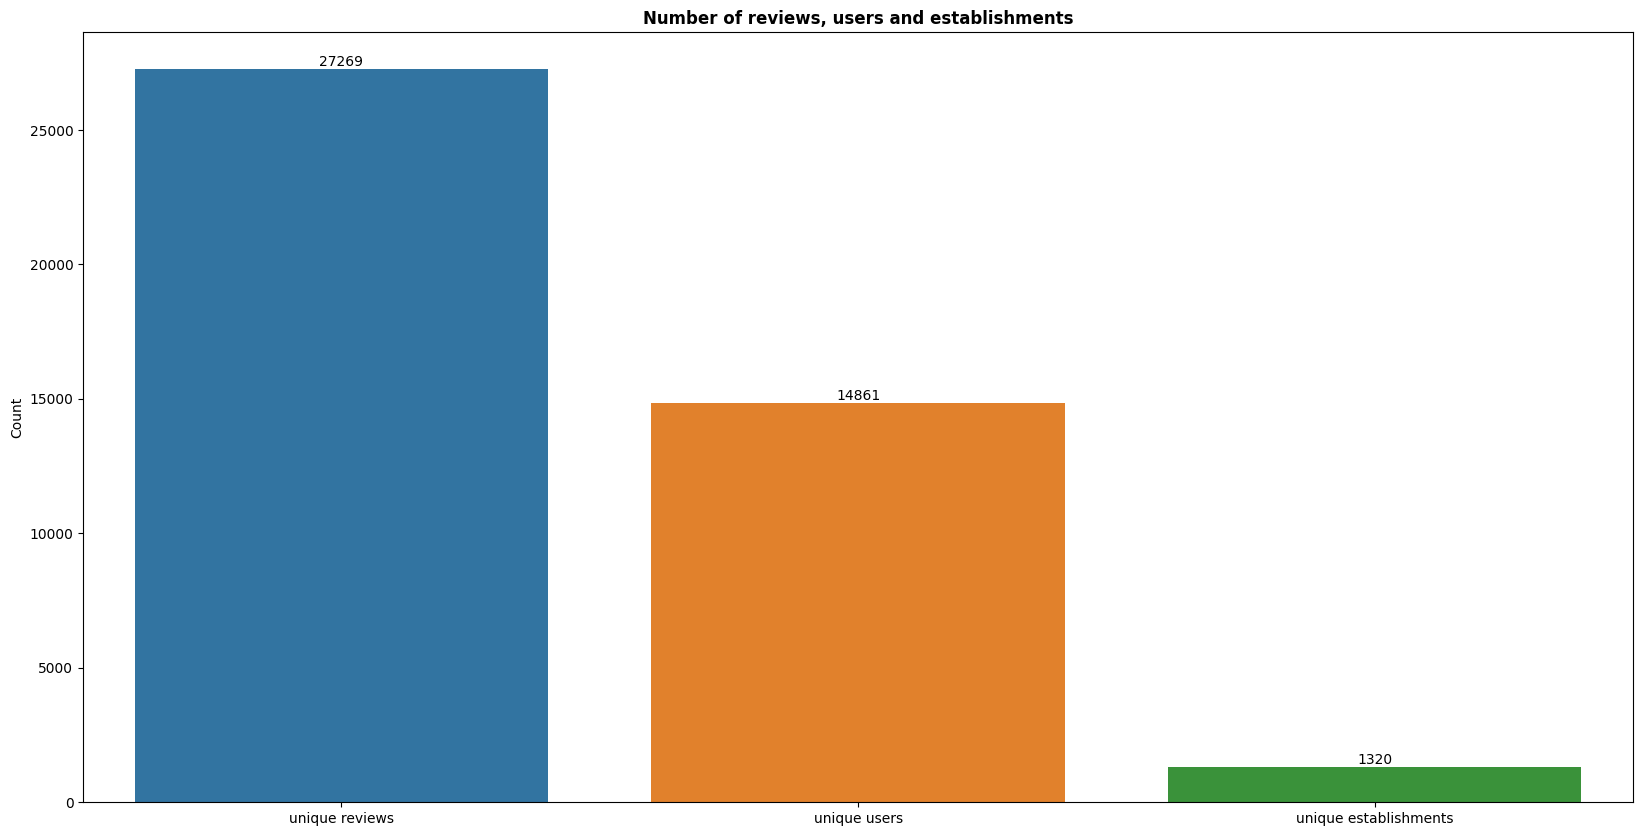

In [8]:
# ploting number of reviews, users and establishments
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=['unique reviews', 'unique users', 'unique establishments'],
            y=[df['review_id'].nunique(), df['user_id'].nunique(), df['business_id'].nunique()])
plt.title('Number of reviews, users and establishments', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.ylabel('Count')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

### conclusions:
1) 14861 users have participated in these reviews
2) there are 1320 different establishments

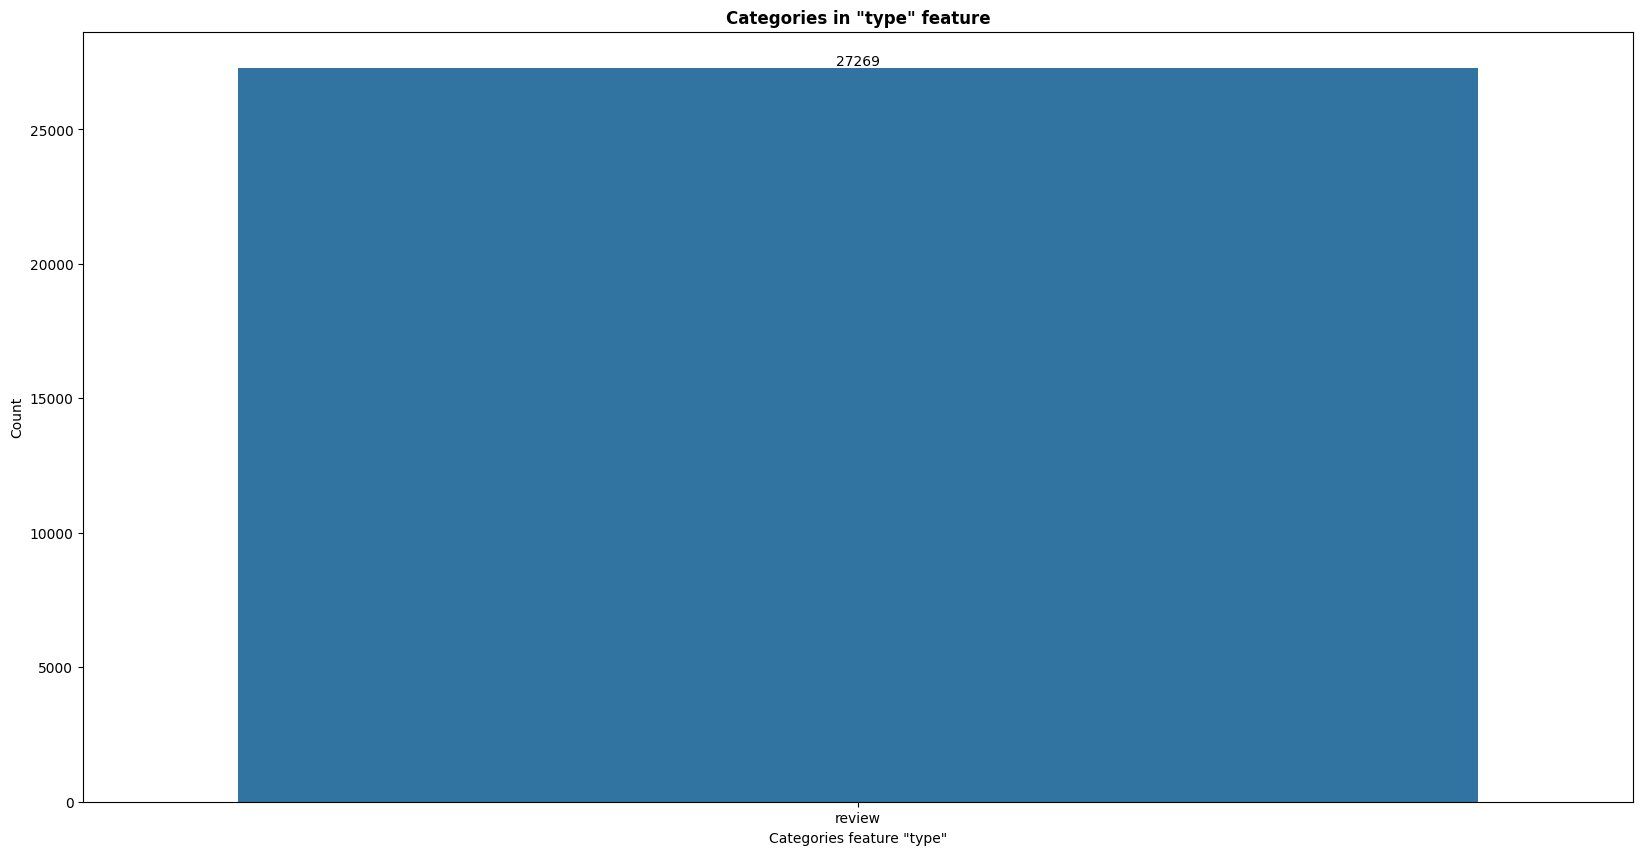

In [9]:
# # countplot in 'type' feature
plt.figure(figsize=(20, 10))
ax = sns.countplot(x=df['type'])
plt.title('Categories in "type" feature', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.xlabel('Categories feature "type"')
plt.ylabel('Count')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

In [10]:
# type' is a no-variance feature, so i will remove
df = df.drop('type', axis=1)

## users

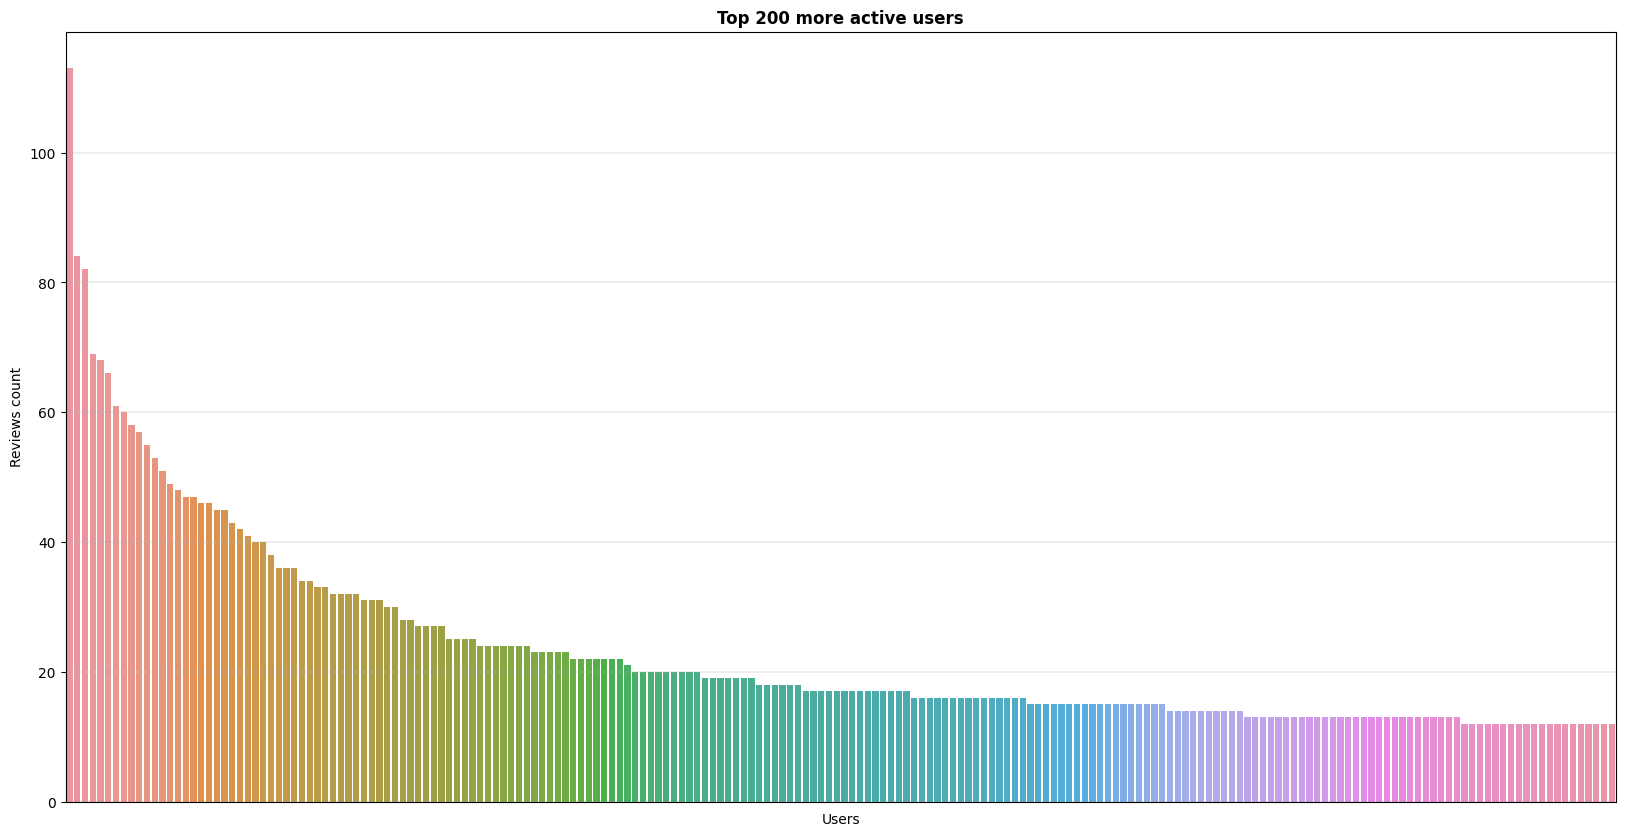

In [11]:
# top 200 more active users
plt.figure(figsize=(20, 10))
sns.barplot(y=df['user_id'].value_counts().head(200).values, x=df['user_id'].value_counts().head(200).index)
plt.grid(linewidth=0.3)
plt.title('Top 200 more active users', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.xlabel('Users')
plt.ylabel('Reviews count')
plt.xticks([])
plt.show()

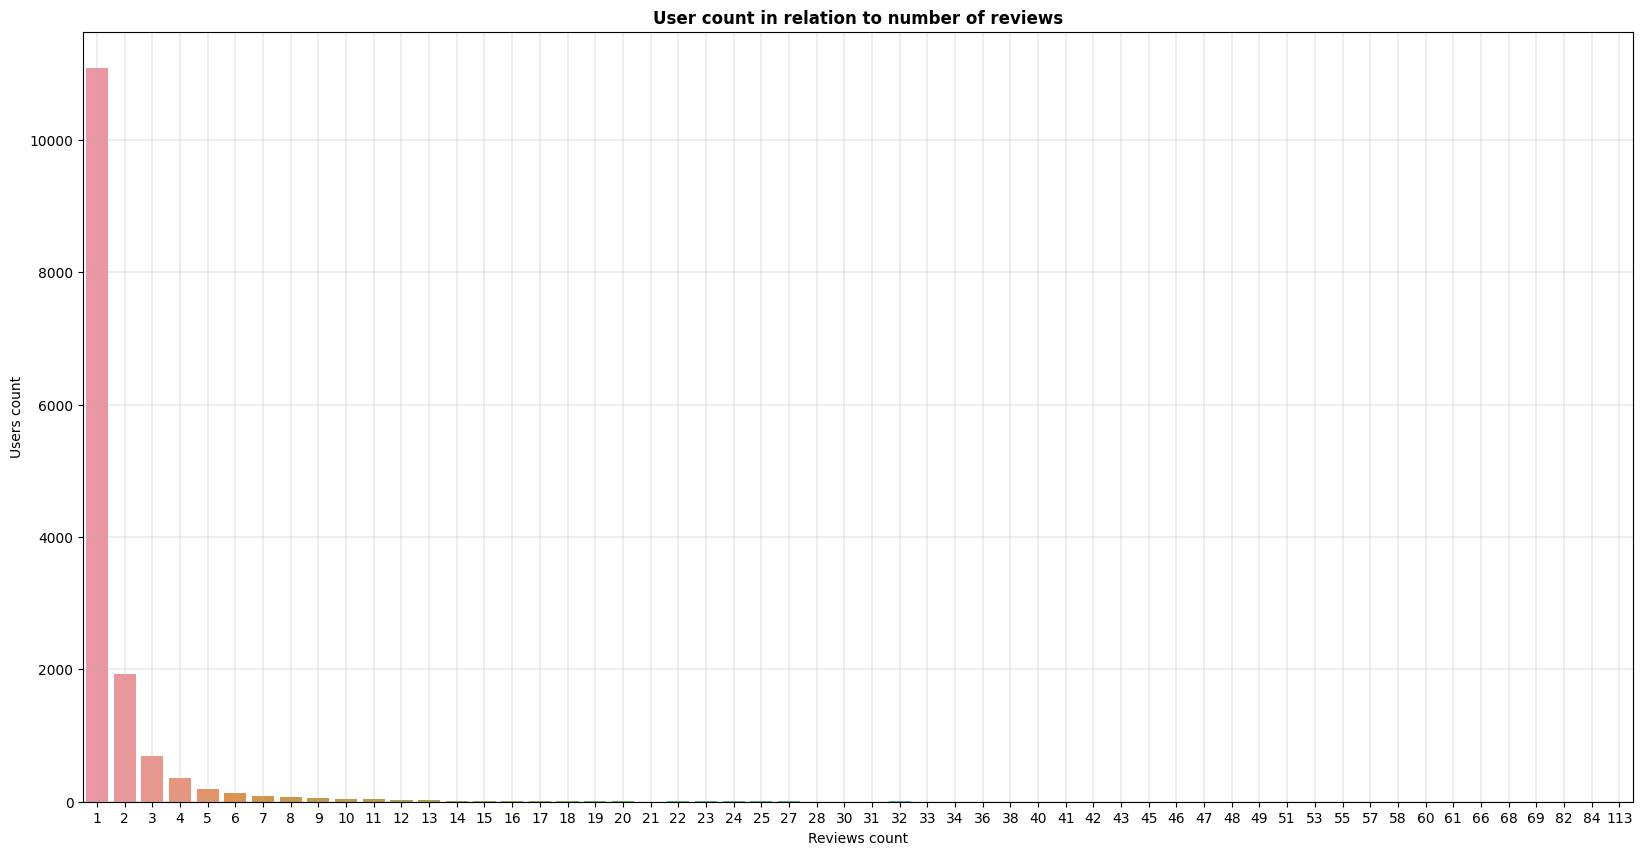

In [12]:
# User count in relation to number of reviews
unique, counts = np.unique(df.value_counts('user_id'), return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(y=counts, x=unique)
plt.grid(linewidth=0.3)
plt.xlabel('Reviews count')
plt.ylabel('Users count')
plt.title('User count in relation to number of reviews', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

## establishments

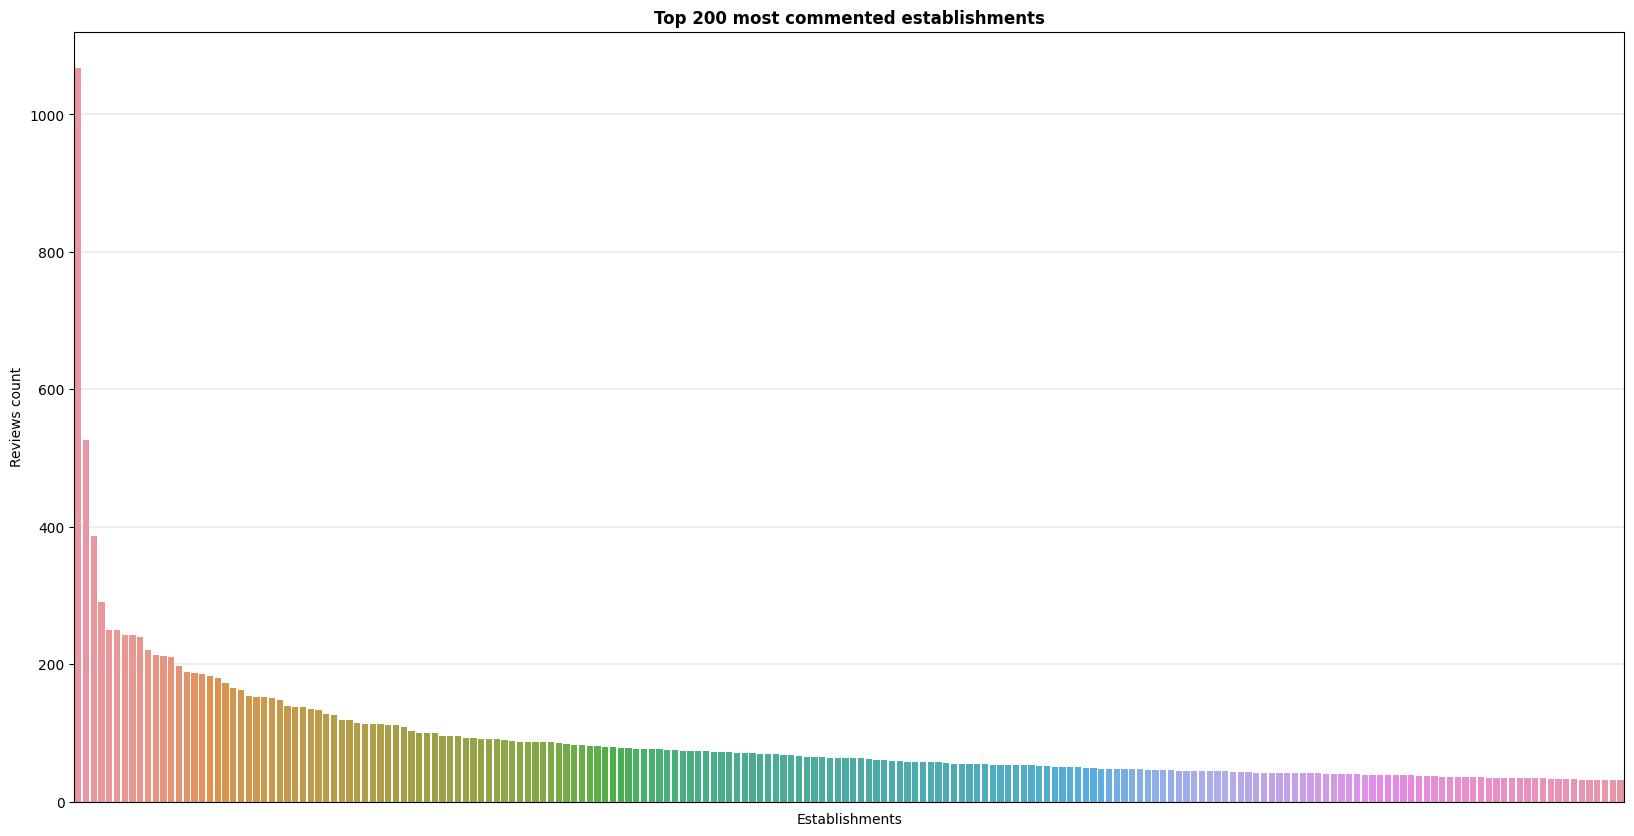

In [13]:
# top 200 most commented establishments
plt.figure(figsize=(20, 10))
sns.barplot(y=df['business_id'].value_counts().head(200).values, x=df['business_id'].value_counts().head(200).index)
plt.grid(linewidth=0.3)
plt.title('Top 200 most commented establishments', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.ylabel('Reviews count')
plt.xlabel('Establishments')
plt.xticks([])
plt.show()

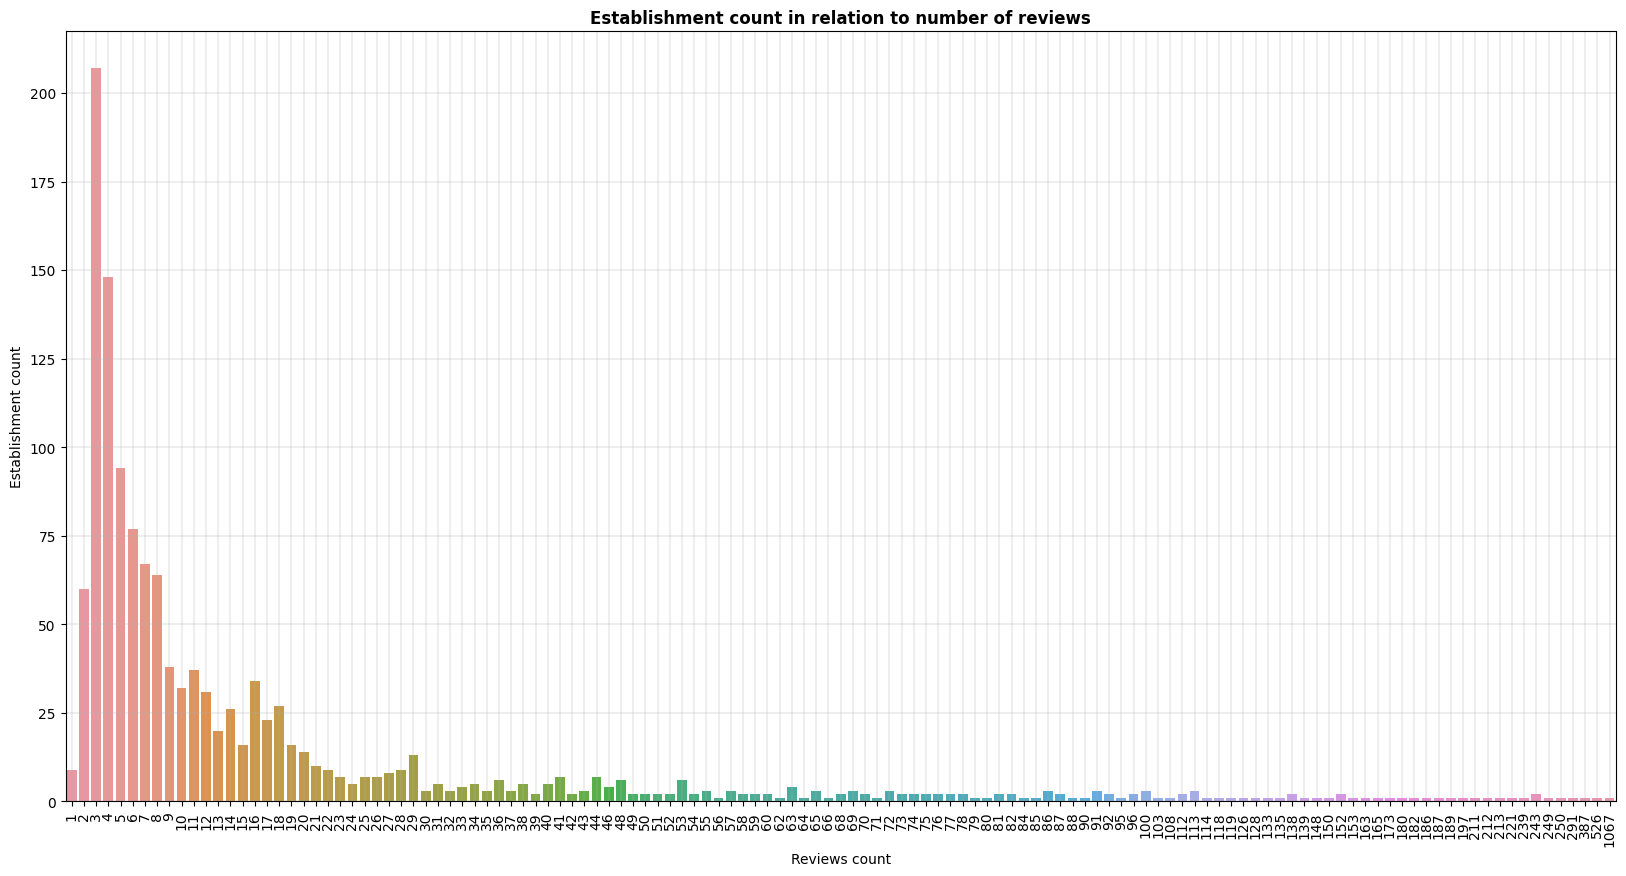

In [14]:
# Establishments count in relation to number of reviews
unique, counts = np.unique(df.value_counts('business_id'), return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(y=counts, x=unique)
plt.grid(linewidth=0.3)
plt.xlabel('Reviews count')
plt.ylabel('Establishment count')
plt.xticks(rotation=90)
plt.title('Establishment count in relation to number of reviews', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

## votes and stars

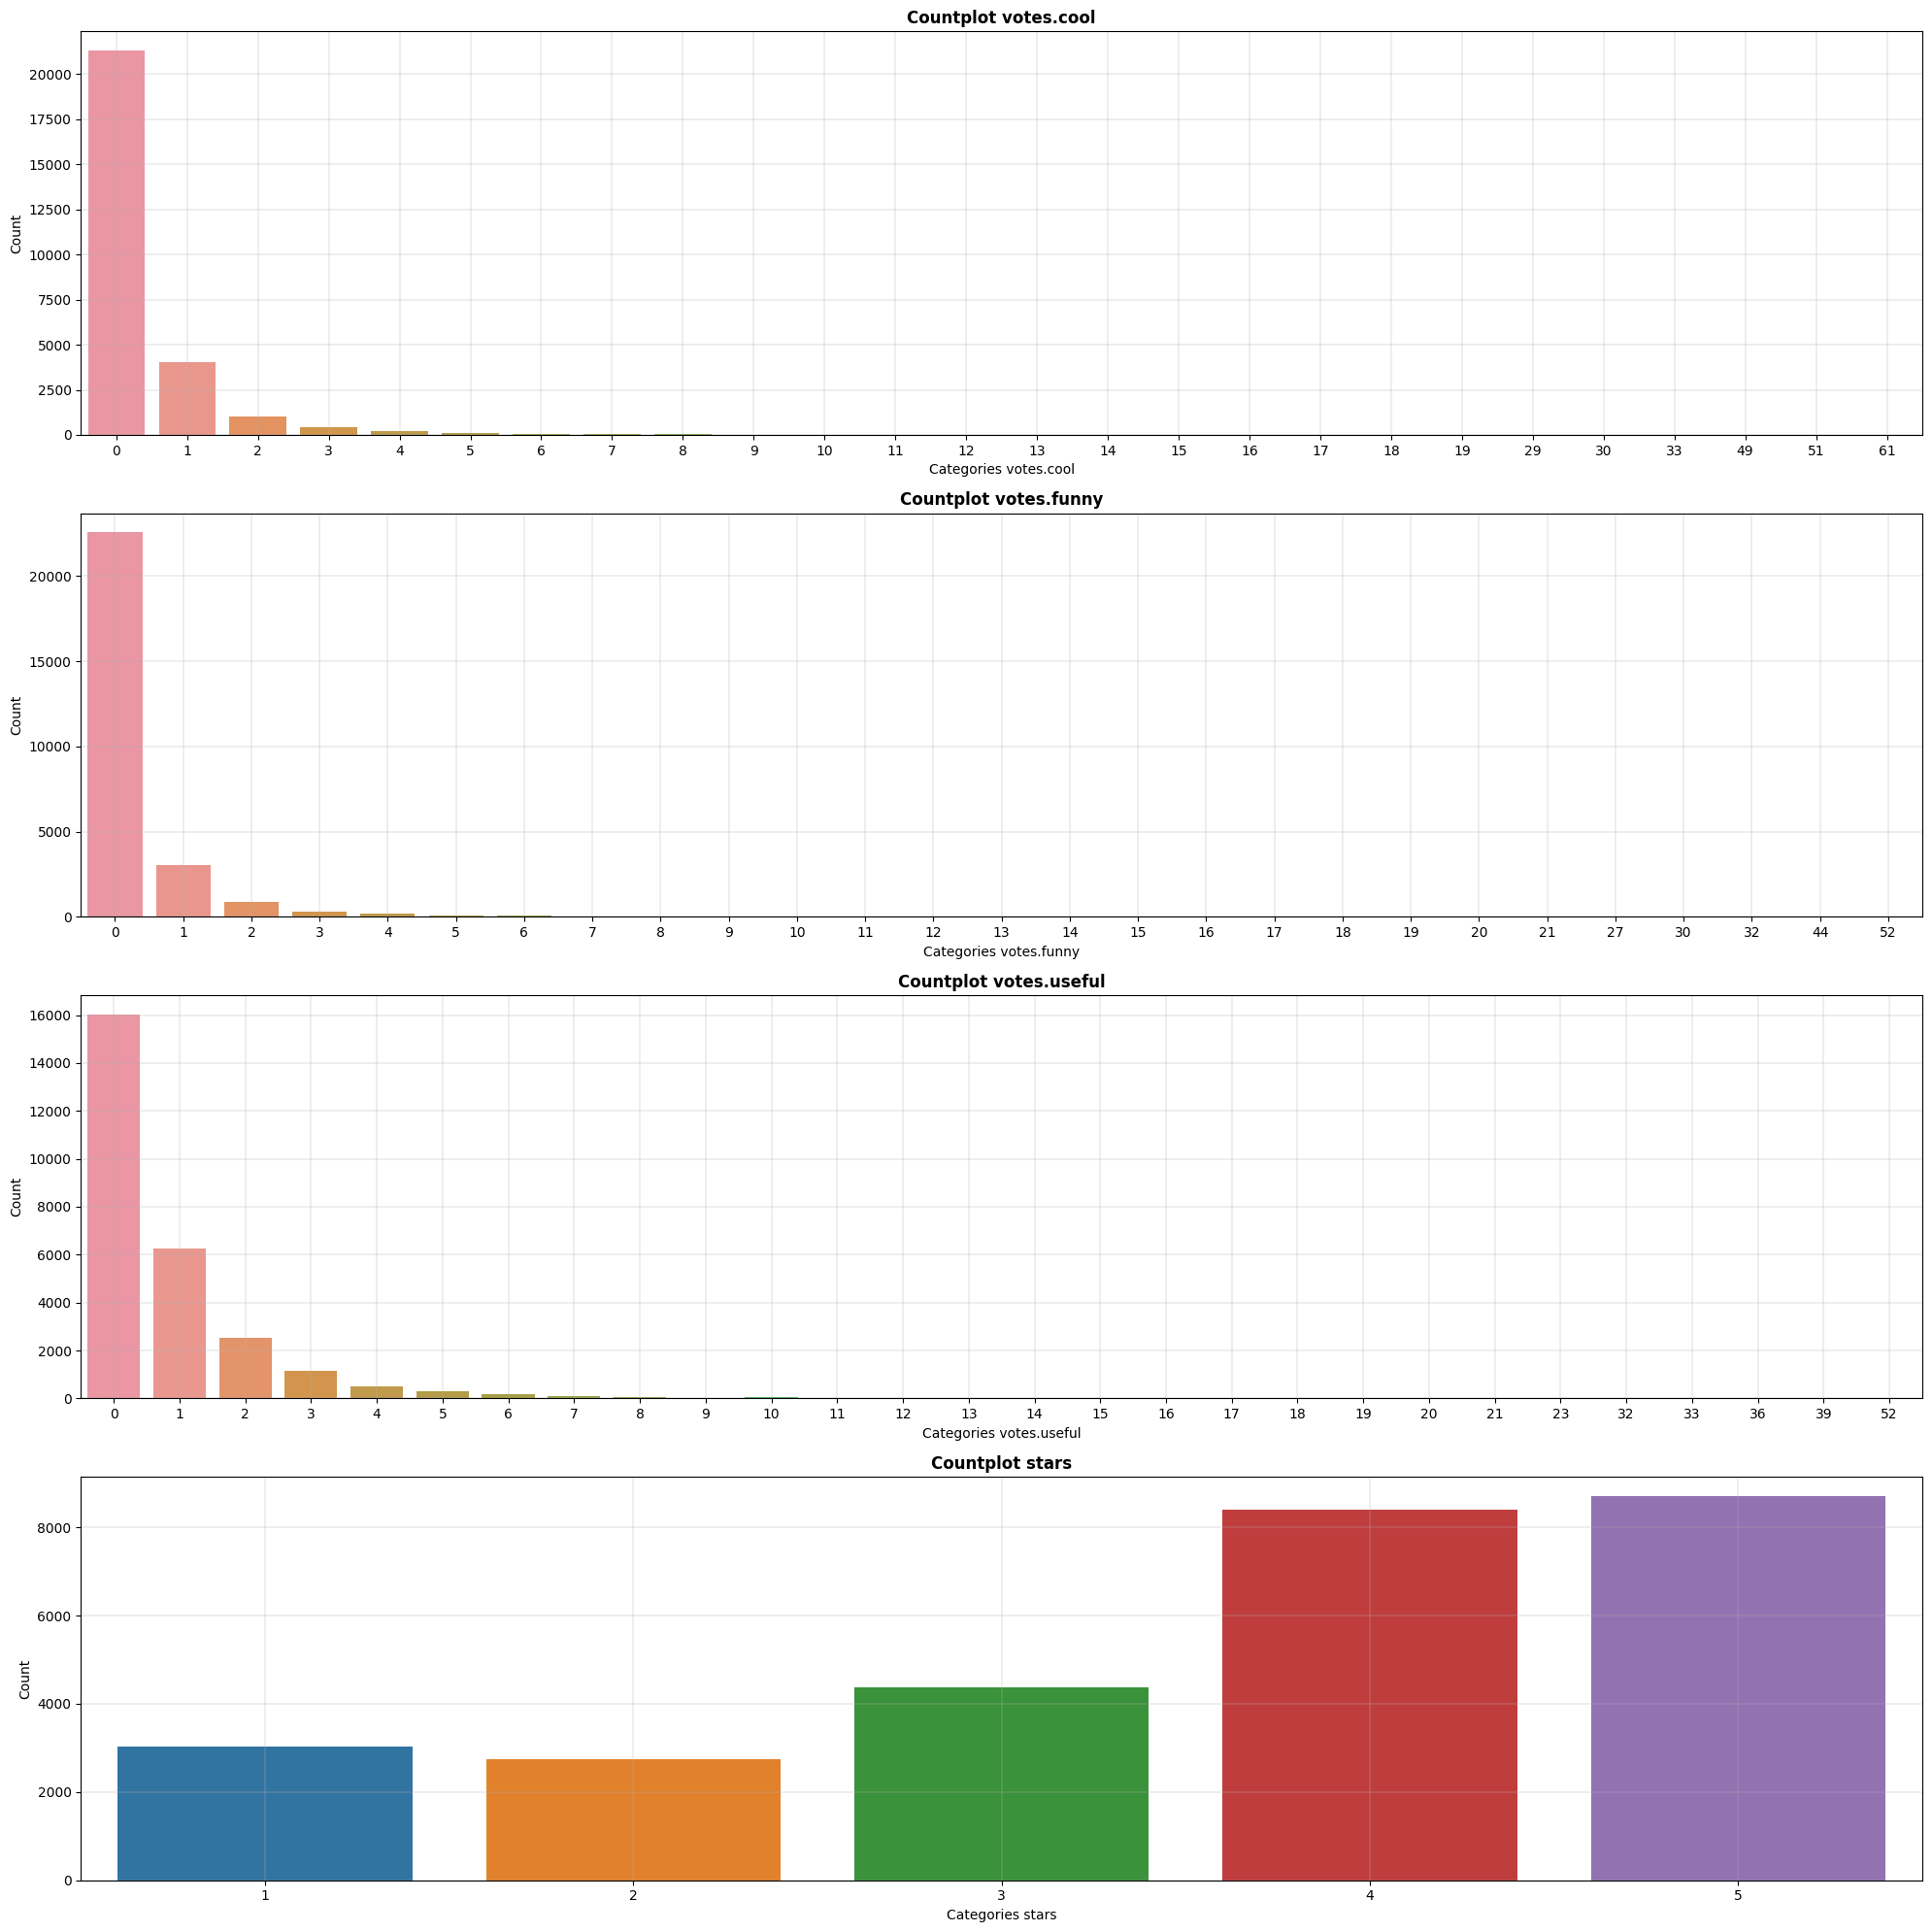

In [15]:
# countplots for votes and stars
features = ['votes.cool', 'votes.funny', 'votes.useful', 'stars']
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20,20))

for i, feature in enumerate(features):
    ax[i] = sns.countplot(x=df[feature], ax=ax[i], order=np.unique(df[feature]))
    ax[i].set_title(f'Countplot {feature}', fontdict={'fontsize': 12,'fontweight':'bold'})
    ax[i].set_ylabel('Count')
    ax[i].set_xlabel(f'Categories {feature}')
    ax[i].grid(linewidth=0.3)
plt.tight_layout()
plt.show()

## length text

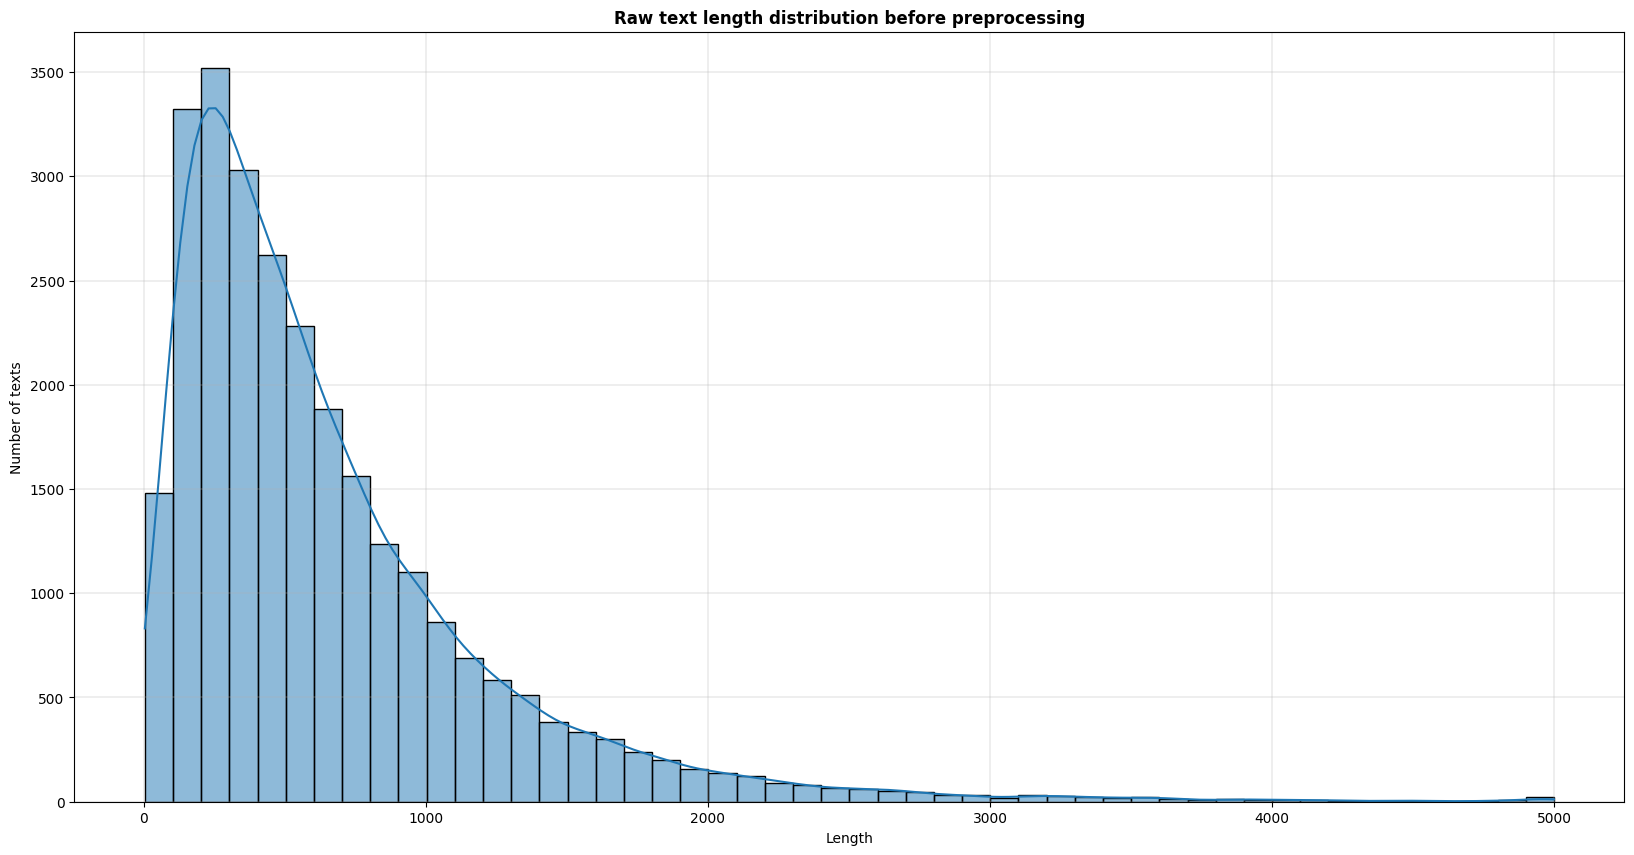

In [16]:
# Raw text length distribution
plt.figure(figsize=(20, 10))
sns.histplot(df['text'].apply(len), kde=True, bins=50)
plt.title('Raw text length distribution before preprocessing', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.ylabel('Number of texts')
plt.xlabel('Length')
plt.grid(linewidth=0.3)
plt.show()

## checking the dates

In [17]:
# transforming date in datetime object
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# spliting date info
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# index modification
df.sort_values(by='date', inplace=True) # sorting by date
df = df.set_index(df['date']) # set date as index
df.drop('date', axis=1, inplace=True) # drop date feature

## reviews through years

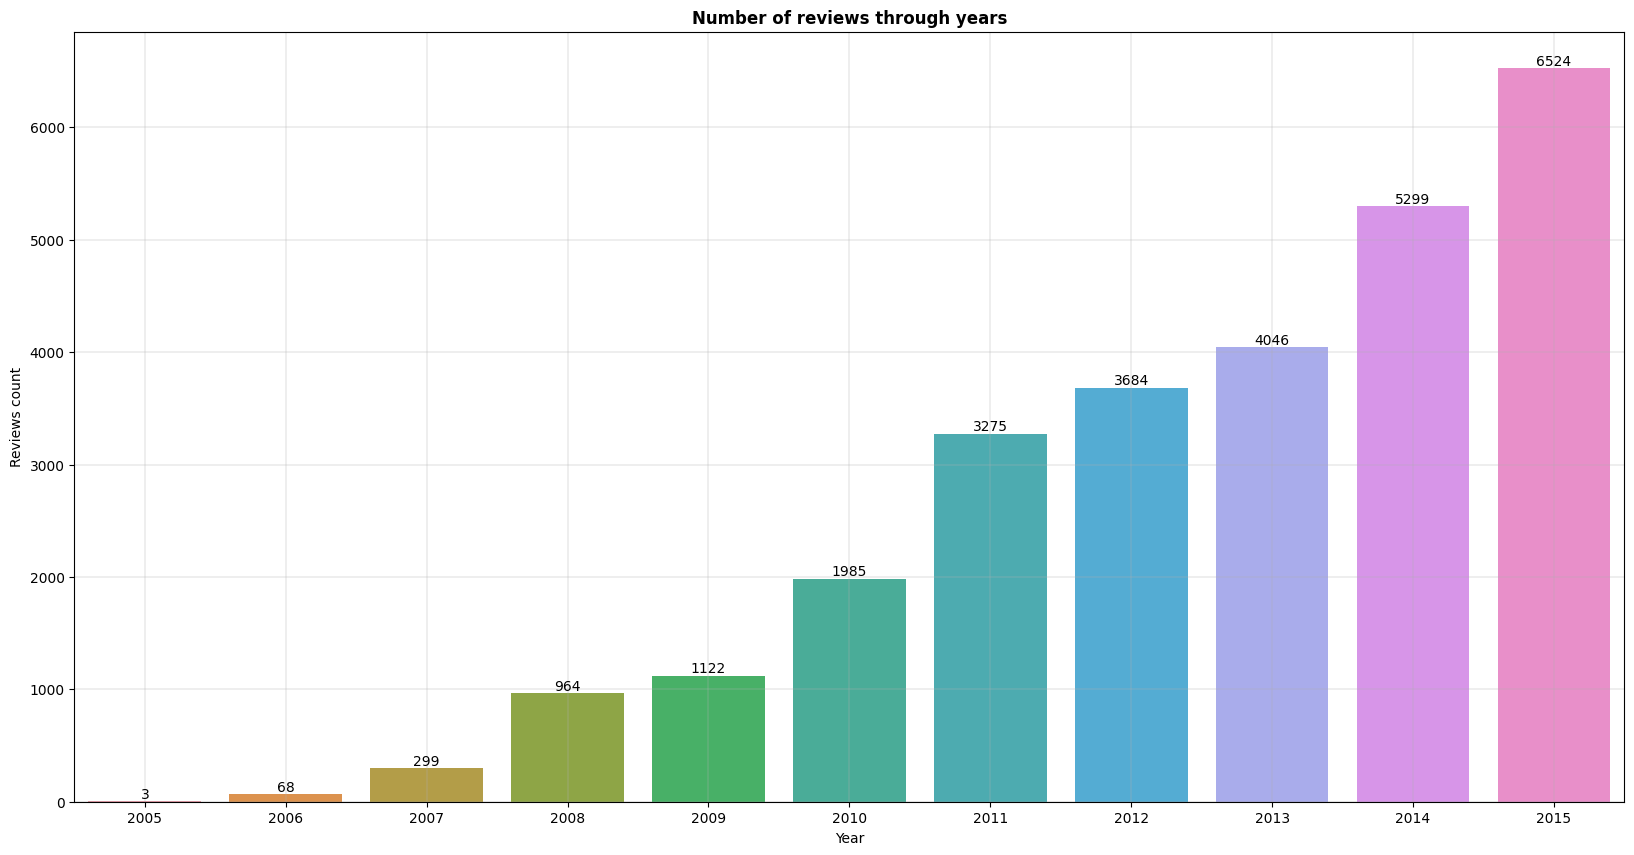

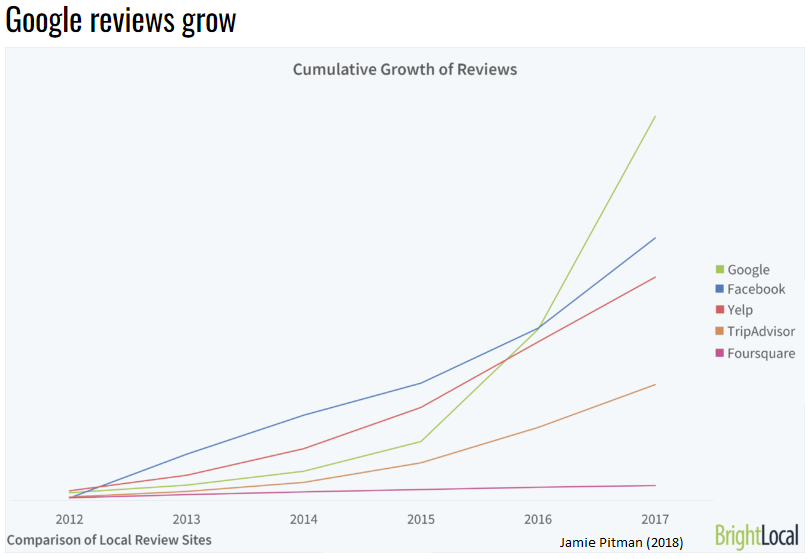

In [18]:
# ploting number of reviews through years
plt.figure(figsize=(20, 10))
ax = sns.countplot(data=df, x='year')
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('Year')
plt.ylabel('Reviews count')
plt.grid(linewidth=0.3)
plt.title('Number of reviews through years', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

# comparison between our dataset reviews and macro analysis
Image('GoogleRevGrow.png')

# Preprocessing

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


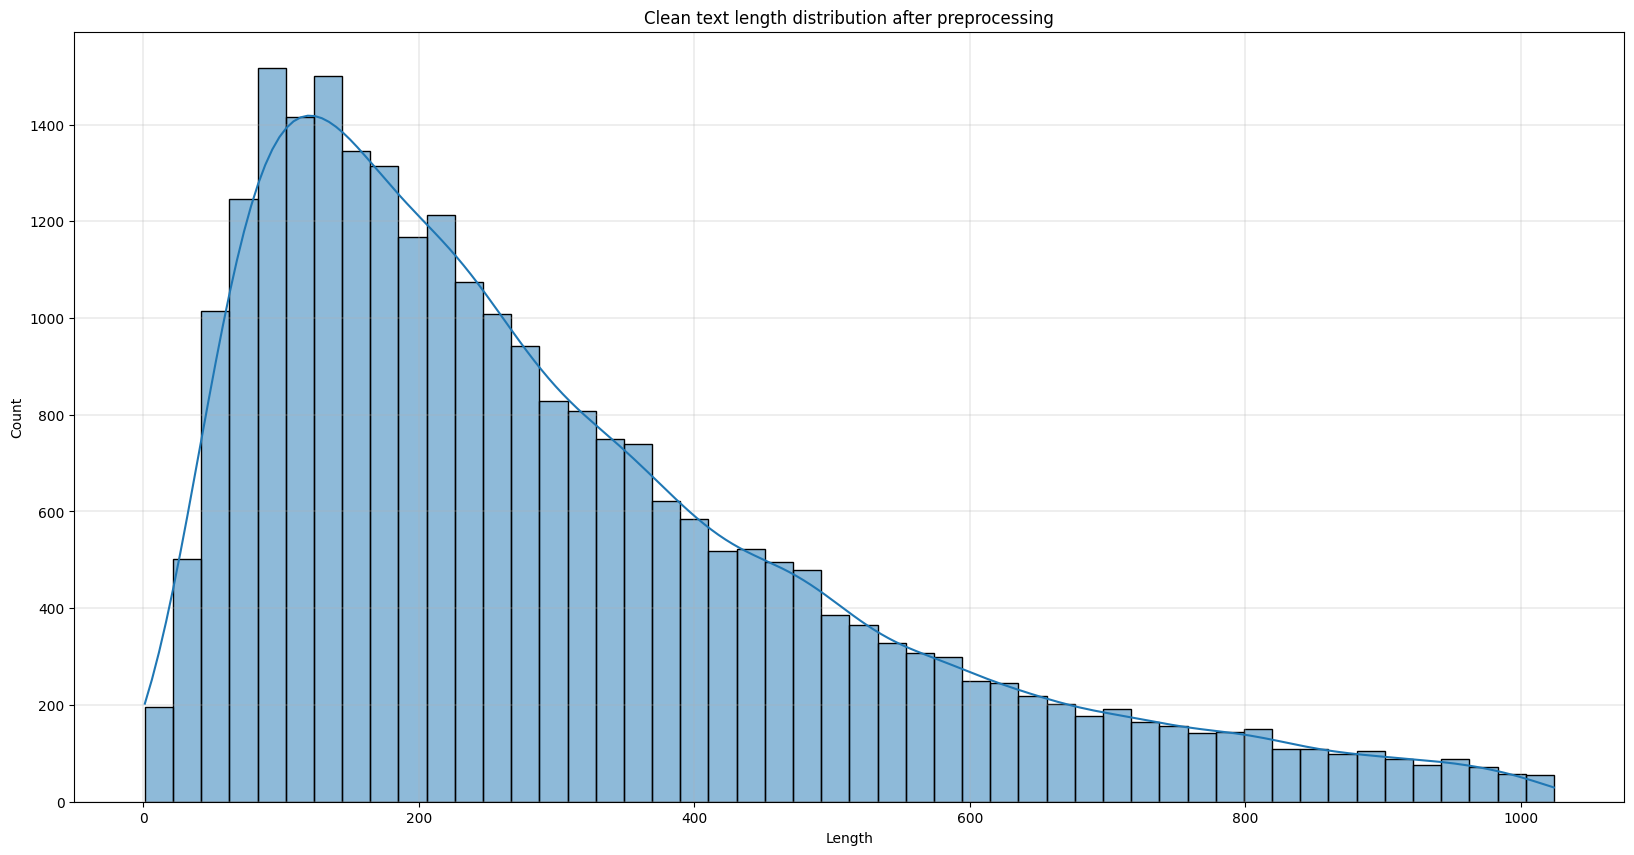

df length before remove reviews > 1024: 26388
df length after remove reviews > 1024: 26388


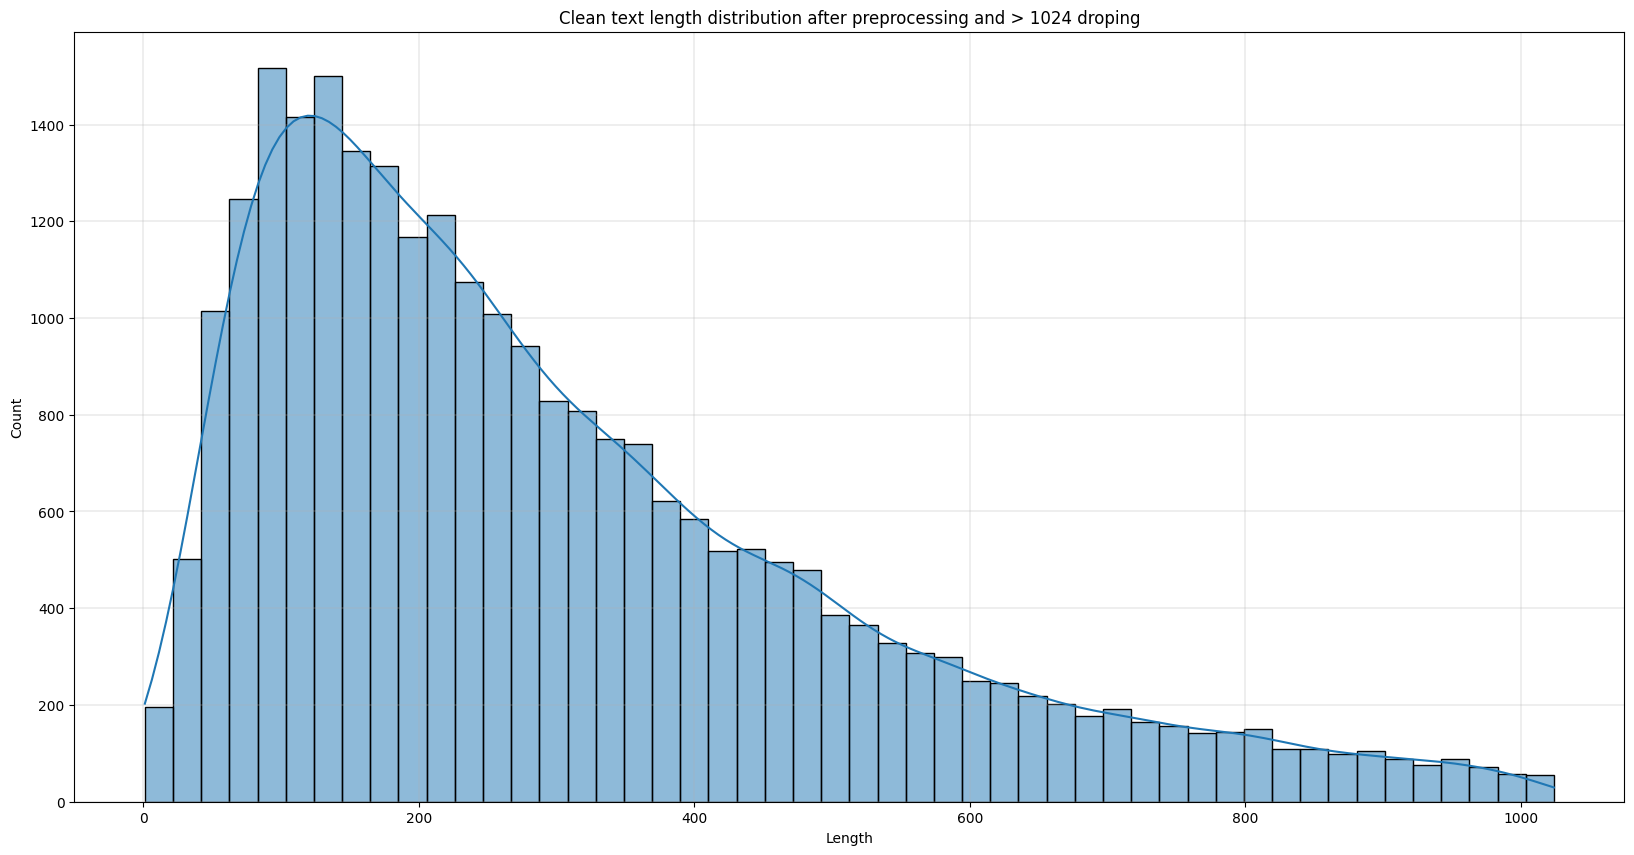

In [154]:
# load spacy model
nlp = spacy.load("en_core_web_lg")

# clean text function (removeHTML)
def removehtml(text):
    """
    Take a text and return a new text without HTML tags
    """
    soup = BeautifulSoup(text)

    return soup.get_text()


# clean text function (stopwords, punctuation and URLs)
def clean_text(text):
    """
    Take a text and return a new text without stopwords, punctuations and URLs
    """
    clean_text = []
    for token in nlp(text):
        if (
            not token.is_stop
            and not token.is_punct
            and not token.like_url
            ):
          clean_text.append(token.lemma_.lower())

    return ' '.join(clean_text)


# clean text function (1 len character)
def remove_character(text):
    """
    Take a text and return a new text without single letters
    """
    return re.sub(r'[^A-Za-z]+', r' ', text)


# clean text function (words containing more than 2 letters repeated)
def remove_duplicates(text):
    """
    Take a text and return a new text without words with more than 2 letters repeated
    """
    return re.sub(r'\b(\w*(\w)\2{2,}\w*)\b', r' ', text)


# function to obtain if the place is bad (1 and 2 stars), netrual (3 stars) or good (4 and 5 stars)
# can be used in get_sentiment_berta to
def binarizer(x):
    """
    take an int and return the category of the place
    """
    if x <= 2:
        return 0
    elif x == 3:
        return 1
    else:
        return 2


# function to get the core text (NOUNs, ADJs, VERBs and ADVs) of review
def get_core(text):
    """
    take a text and obtain the NOUNs, ADJs, VERBs and ADVs
    """
    text = nlp(text)
    core_text = []
    for token in text:
        if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']:
            core_text.append(token.text)
    return ' '.join(core_text)


# get sentiment function (with textblob)
def get_sentiment_blob(text):
    """
    take a text and get the sentiment:
    -1: negative
    0: neutral
    1: positive
    """
    sentiment = TextBlob(text).sentiment.polarity
    if sentiment < -0.3:
        return 0
    elif sentiment >= -0.3 and sentiment <= 0.3:
        return 1
    elif sentiment > 0.3:
        return 2


# get sentiments with bert
bert_model_name = 'nlptown/bert-base-multilingual-uncased-sentiment' # model_name
bert_model = TFAutoModelForSequenceClassification.from_pretrained(bert_model_name, from_pt=True) # model instance, 'from_pt' flag to import the model in tensorflow
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name) # take string data and transform in numerical data
bert_sentiment_classifier = pipeline('sentiment-analysis', model=bert_model, tokenizer=bert_tokenizer)

# bert has a 512 tokens length limit
# function to process and obtain sentiment of text with a token length between 0 and 1024
def get_sentiment_bert(text, model=bert_sentiment_classifier):
    sentiment = None
    if len(text) < 512:
        return int(bert_sentiment_classifier(text)[0]['label'][0])
    else: # if the text has more than 512 tokens, it is divided in two, both sentiments are obtained and the sum is averaged
        list_ = []
        list_.append(float(bert_sentiment_classifier(text[0:511])[0]['label'][0]))
        list_.append(float(bert_sentiment_classifier(text[512:len(text)])[0]['label'][0]))
        return round(np.mean(list_))


# apply functions
df['clean_text'] = df['text'].apply(remove_duplicates)
df['clean_text'] = df['clean_text'].apply(removehtml)
df['clean_text'] = df['clean_text'].apply(clean_text)
df['clean_text'] = df['clean_text'].apply(remove_character)
df['core_text'] = df['clean_text'].apply(get_core)
df['category_stars'] = df['stars'].apply(binarizer) # binarize the stars in negative, neutral and positive

# clean text length distribution after preprocessing
plt.figure(figsize=(20, 10))
sns.histplot(df['clean_text'].apply(len), kde=True, bins=50)
plt.title('Clean text length distribution after preprocessing')
plt.ylabel('Count')
plt.xlabel('Length')
plt.grid(linewidth=0.3)
plt.show()

# i only use reviews with n_tokens <= 1024
print(f'df length before remove reviews > 1024: {len(df)}')
df = df[df["clean_text"].apply(len) <= 1024]
print(f'df length after remove reviews > 1024: {len(df)}')

# clean text length distribution after preprocessing and > 1024 droping
plt.figure(figsize=(20, 10))
sns.histplot(df['clean_text'].apply(len), kde=True, bins=50)
plt.title('Clean text length distribution after preprocessing and > 1024 droping')
plt.ylabel('Count')
plt.xlabel('Length')
plt.grid(linewidth=0.3)
plt.show()

df['sentiment_blob'] = df['clean_text'].apply(get_sentiment_blob)
df['sentiment_bert_clean'] = df['clean_text'].apply(get_sentiment_bert) # 'nlptown/bert-base-multilingual-uncased-sentiment' has 5 possible outputs
df['sentiment_bert_clean_bina'] = df['sentiment_bert_clean'].apply(binarizer) # binarize the bert outputs in negative, neutral and positive
df['sentiment_bert_core'] = df['core_text'].apply(get_sentiment_bert) # 'nlptown/bert-base-multilingual-uncased-sentiment' has 5 possible outputs
df['sentiment_bert_core_bina'] = df['sentiment_bert_core'].apply(binarizer) # binarize the bert outputs in negative, neutral and positive

# removing NaNs in 'core_text' (some clean_text may not contain the selected NERs)
df.drop(labels=df.loc[df['core_text'].isna()].index, axis=0, inplace=True)

# obtaining keywords
kw_model = KeyBERT()
df['keywords'] = df['clean_text'].apply(lambda x: kw_model.extract_keywords(x, keyphrase_ngram_range=(1, 1), use_mmr=True, diversity=0.4, top_n=3)) # use_mmr and diversity are used to extract more diverse keywords
df['keywords'] = df['keywords'].apply(lambda keywords: [k[0] for k in keywords]) # extract the keywords str from the list
# df['keywords'] = df['keywords'].str.join(' ') # joining the keywords in a single str

## wordcloud

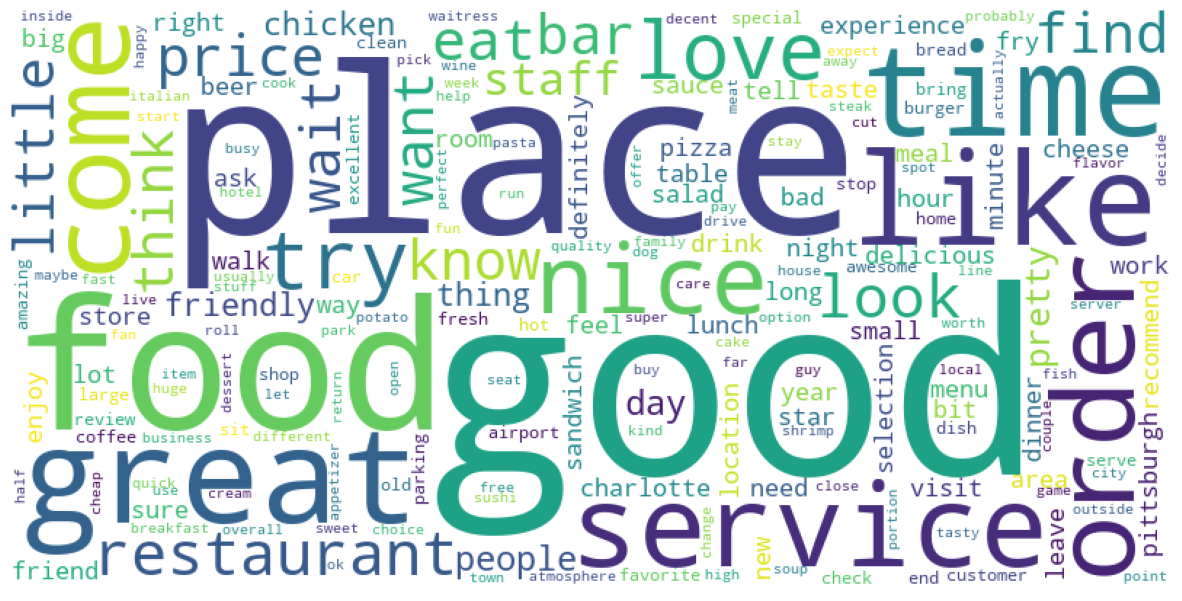

In [161]:
# ploting wordcloud
wordcloud = WordCloud(collocations = False,
                      background_color = 'white',
                      width = 800, height = 400,
                      stopwords = nlp.Defaults.stop_words,
                      ).generate(' '.join(df['clean_text'].values))

plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## most popular keywords

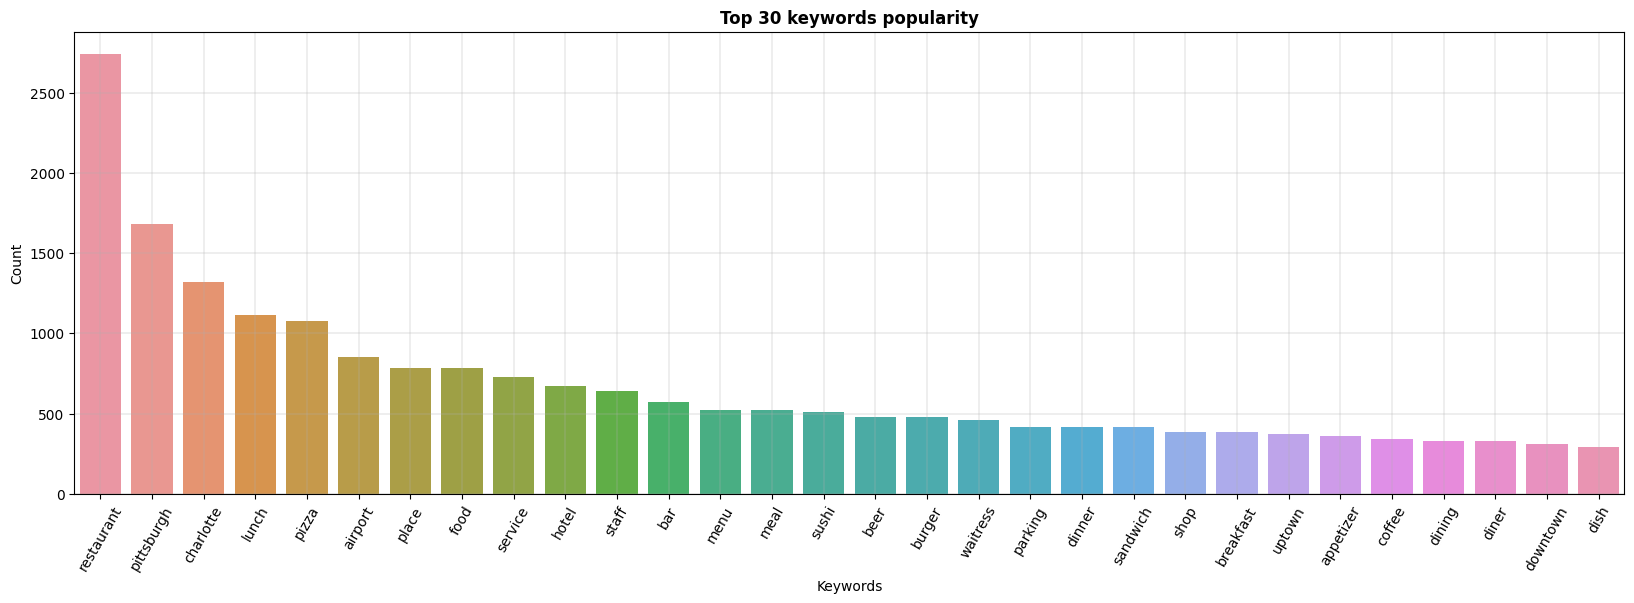

In [180]:
# ploting most popular keywords
plt.figure(figsize=(20,6))
sns.countplot(x=df.explode('keywords')['keywords'],
              order=df.explode('keywords')['keywords'].value_counts().index[:30]
              )
plt.grid(linewidth=0.3)
plt.title('Top 30 keywords popularity', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.ylabel('Count')
plt.xlabel('Keywords')
plt.xticks(rotation=60)
plt.show()

## evolution of the reviews through months and years

In [182]:
# plot function to describe the evolution of the reviews through months and years
def plot_evolution_reviews(x, negative, neutral, positive, establishment):
    """
    Function to plot the evolution of the reviews
    x: 1d array with the dates
    negative, neutral and positive: 1d arrays with the count of the sentiment analysis by units of date
    All the arrays must have the same length
    """
    line_plot3 = plt.figure(figsize=(22, 10), dpi=80)
    plt.plot(x,
            negative,
            color='red',
            linewidth=1,
            label='negative')
    plt.plot(x,
            neutral,
            color='blue',
            linewidth=1,
            label='neutral')
    plt.plot(x,
            positive,
            color='green',
            linewidth=.5,
            label='positive')

    plt.grid(linewidth=0.3)
    plt.legend(loc='upper left')
    plt.title(f'Evolution of the reviews through months and years. Establishment: {establishment}', fontdict={'fontsize': 12,'fontweight':'bold'})
    plt.xticks(rotation=90)
    plt.xlabel('Date [month-year]')
    plt.ylabel(f'Number of reviews')
    plt.tight_layout()

# function to describe the evolution of the reviews through months and years, could be used with the entire the dataset or with a punctual establishment
def evolution_reviews(df, sentiment_column_name, establishment_column_name=None, establishment=None):
    """
    Function to plot the evolution of the reviews, could be used with the entire the dataset or with a punctual establishment
    df is a pd.DataFrame with 'year', 'month' and sentiment with 3 unique values
    sentiment_column_name: str
    establishment_column_name: str
    establishment: str
    """
    df_aux = df.copy()
    if establishment == None:
        df_aux[['negative', 'neutral', 'positive']] = tf.one_hot(df_aux[sentiment_column_name], df_aux[sentiment_column_name].nunique()) # encoding the sentiment
        aux = df_aux.groupby(['year', 'month'], as_index=False).aggregate({'negative': 'sum', 'neutral': 'sum', 'positive': 'sum'}) # grouping by year and month and count the sentiments
        for index in range(0, len(aux), 1): # creating an unique feature month + year
            aux['month'][index] = str(aux['month'][index]) + '-' + str(aux['year'][index])
        plot_evolution_reviews(aux['month'], aux['negative'], aux['neutral'], aux['positive'], establishment='all dataset') # ploting with the function

    else:
        df_aux[['negative', 'neutral', 'positive']] = tf.one_hot(df_aux[sentiment_column_name], df_aux[sentiment_column_name].nunique()) # encoding the sentiment
        aux = df_aux.loc[df_aux[establishment_column_name] == establishment] # filtering by establishment
        aux = aux.groupby(['year', 'month'], as_index=False).aggregate({'negative': 'sum', 'neutral': 'sum', 'positive': 'sum'}) # grouping by year and month and count the sentiments
        for index in range(0, len(aux), 1): # creating an unique feature month + year
            aux['month'][index] = str(aux['month'][index]) + '-' + str(aux['year'][index])
        plot_evolution_reviews(aux['month'], aux['negative'], aux['neutral'], aux['positive'], establishment=establishment) # ploting with the function

C:\Users\fer\AppData\Local\Temp\ipykernel_3776\3873117340.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['month'][index] = str(aux['month'][index]) + '-' + str(aux['year'][index])
C:\Users\fer\AppData\Local\Temp\ipykernel_3776\3873117340.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['month'][index] = str(aux['month'][index]) + '-' + str(aux['year'][index])


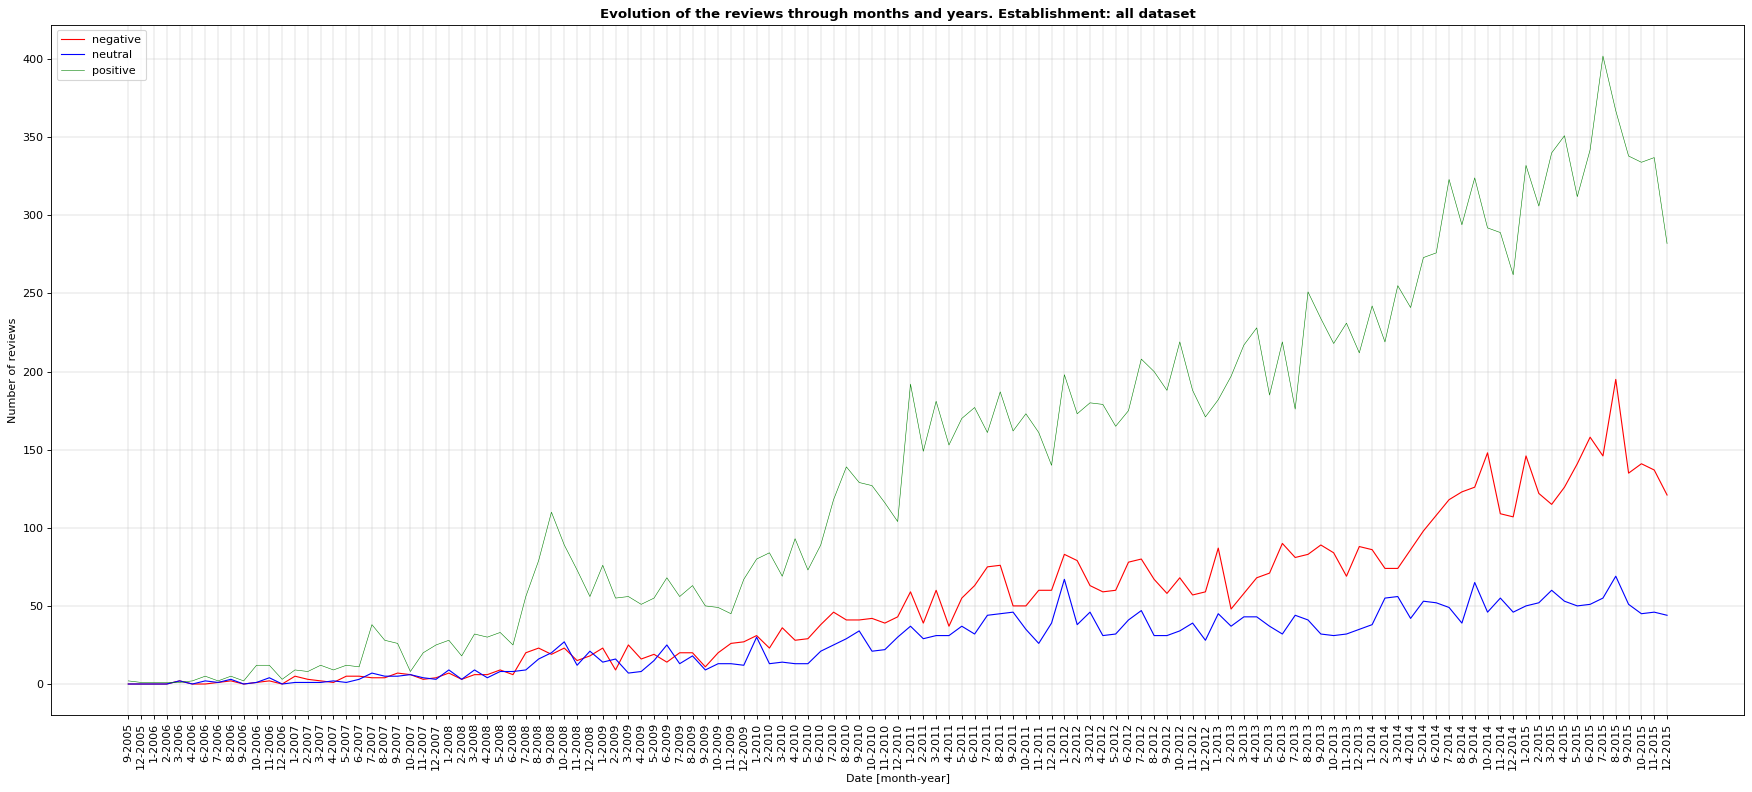

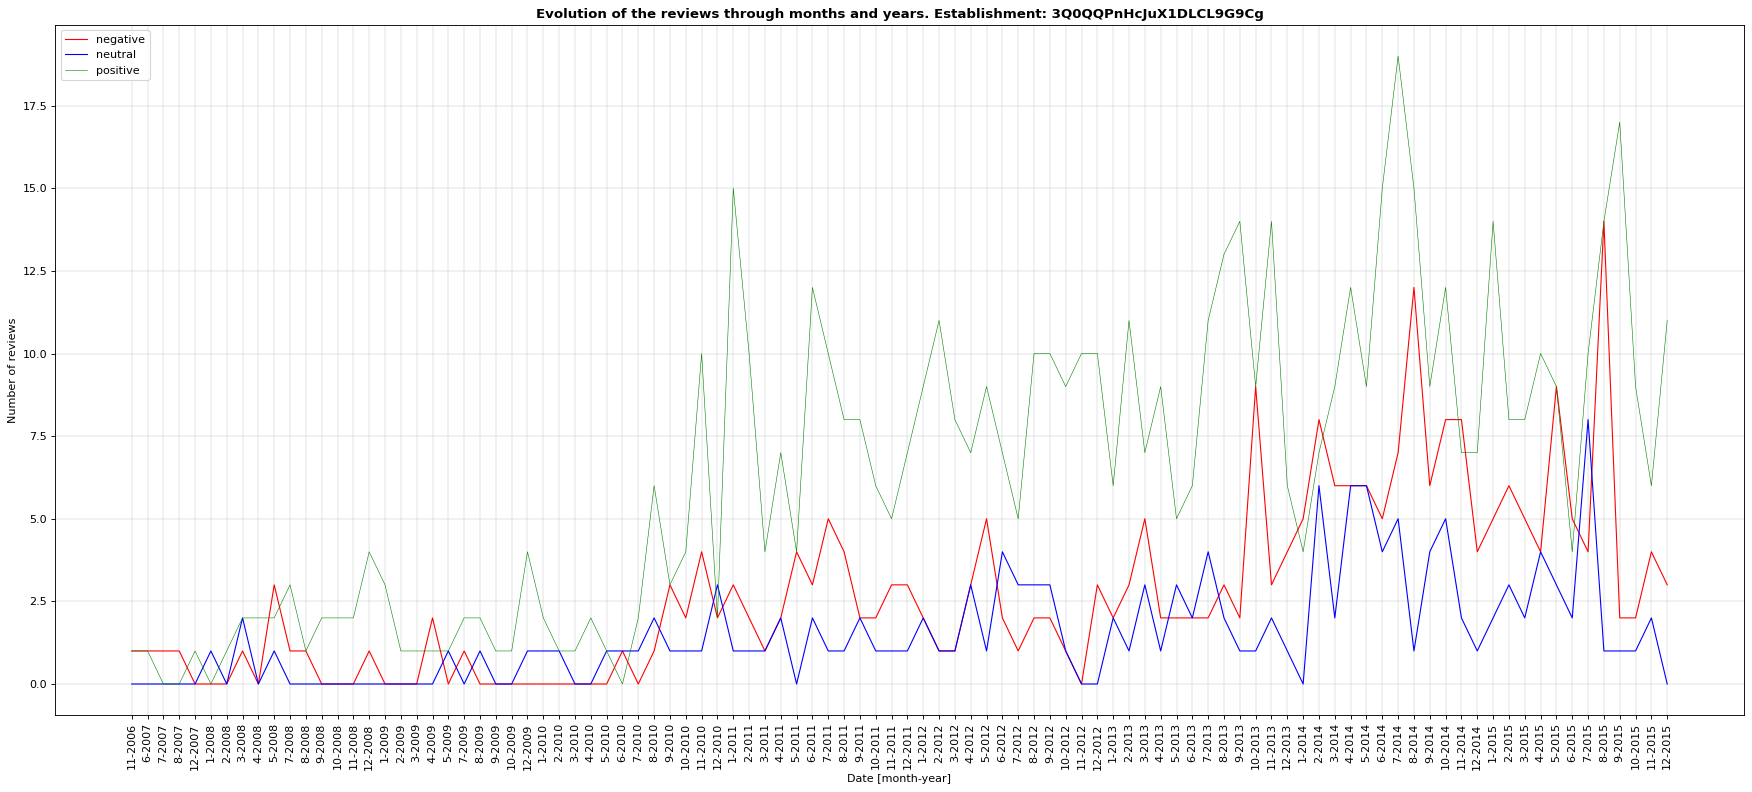

In [183]:
# ploting the evolution of the reviews through months and years of all datase
evolution_reviews(df, 'sentiment_bert_clean_bina', establishment=None)

# ploting the evolution of the reviews through months and years of most commented establishment
most_commented_establishment = df.groupby('business_id', as_index=False).aggregate({'text': 'count'}).sort_values('text', ascending=False).head(1)['business_id'].values[0]
evolution_reviews(df, 'sentiment_bert_clean_bina', establishment_column_name='business_id', establishment=most_commented_establishment)

## relation between number of reviews and positive / negative ratio

In [19]:
# twinx lineplot function
def twice_lineplot(x, yLeft, yRight, title, labelYLeft, labelYRight):
    """
    x: 1d array which represent the X axis
    yLeft and yRight: 1d arrays which represent Y1 and Y2 axis
    title, labelYLeft and labelYRight: str
    """
    fig, ax1 = plt.subplots(figsize=(20, 10))

    ax1.plot(x, yLeft, color='blue')
    ax2 = ax1.twinx()
    ax1.set_title(title, fontdict={'fontsize': 12,'fontweight':'bold'})
    ax1.set_xlabel('Establishments')
    ax1.set_ylabel(labelYLeft, color='blue')
    ax1.set_yticks(np.arange(0, np.max(yLeft)+1, 50))
    ax2.set_yticks(np.arange(0, np.max(yRight)+1, 1))
    ax2.plot(x, yRight, color='green')
    ax2.set_ylabel(labelYRight, color='green')
    ax1.tick_params(labelrotation=90)
    ax1.tick_params(axis='x', which='major', labelsize=8)
    ax1.grid(linewidth=0.3)

    plt.show()

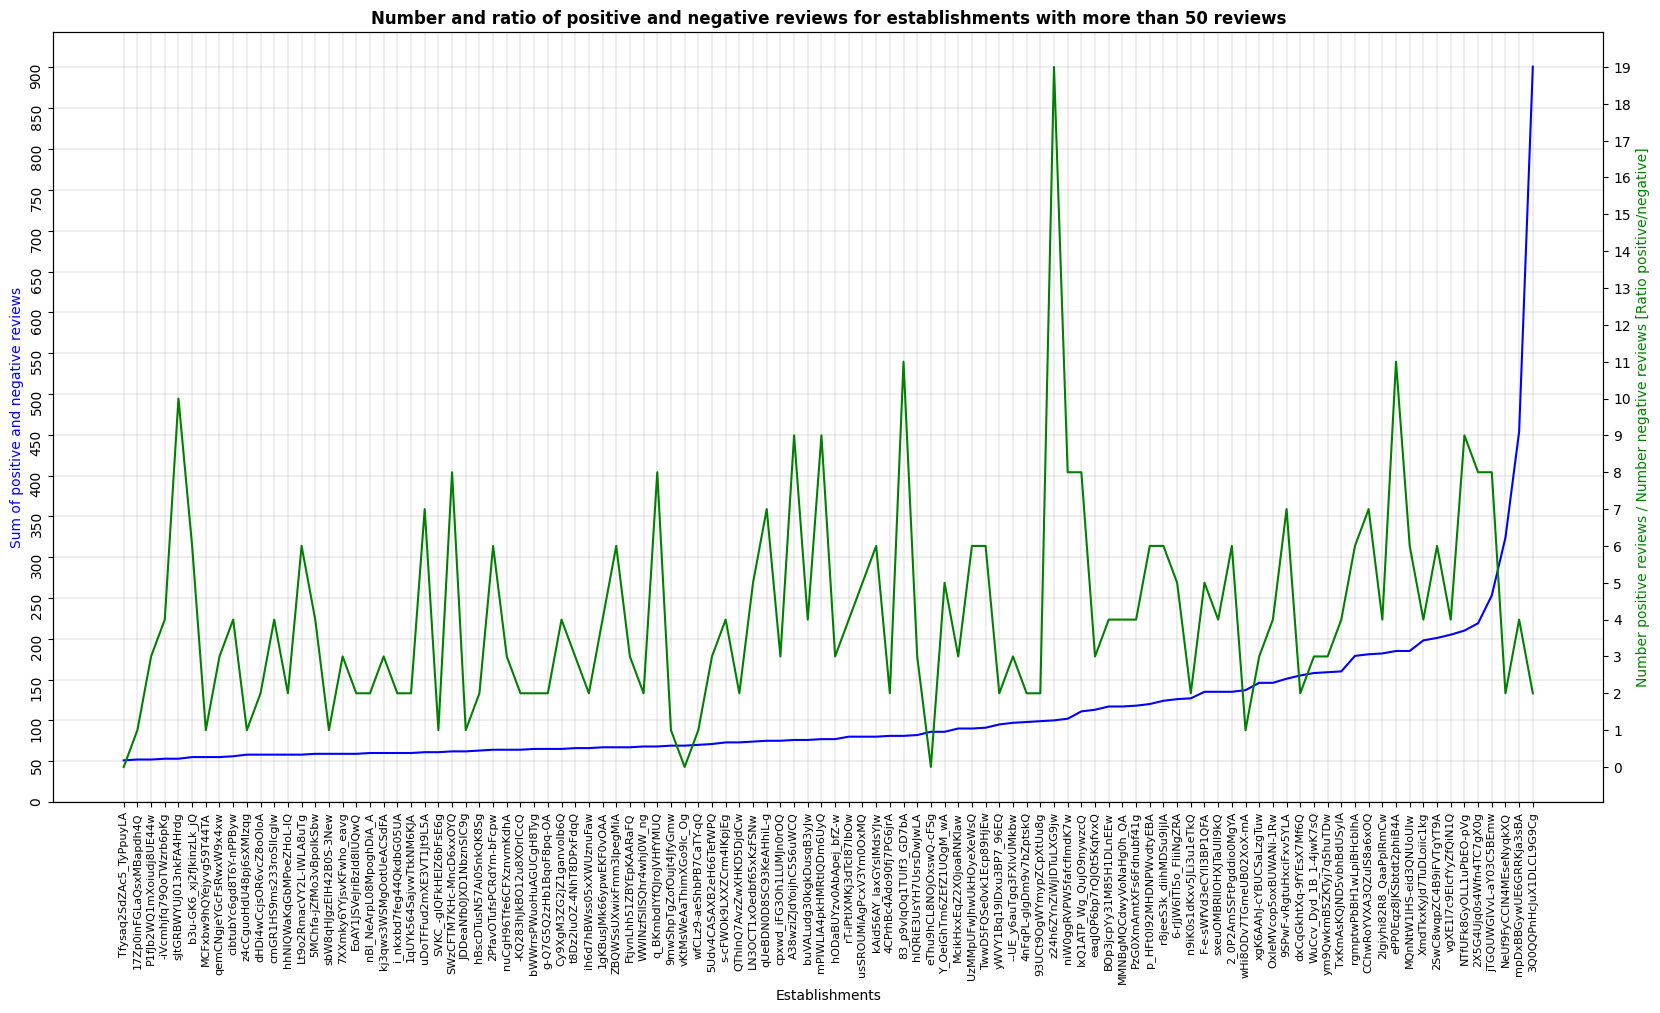

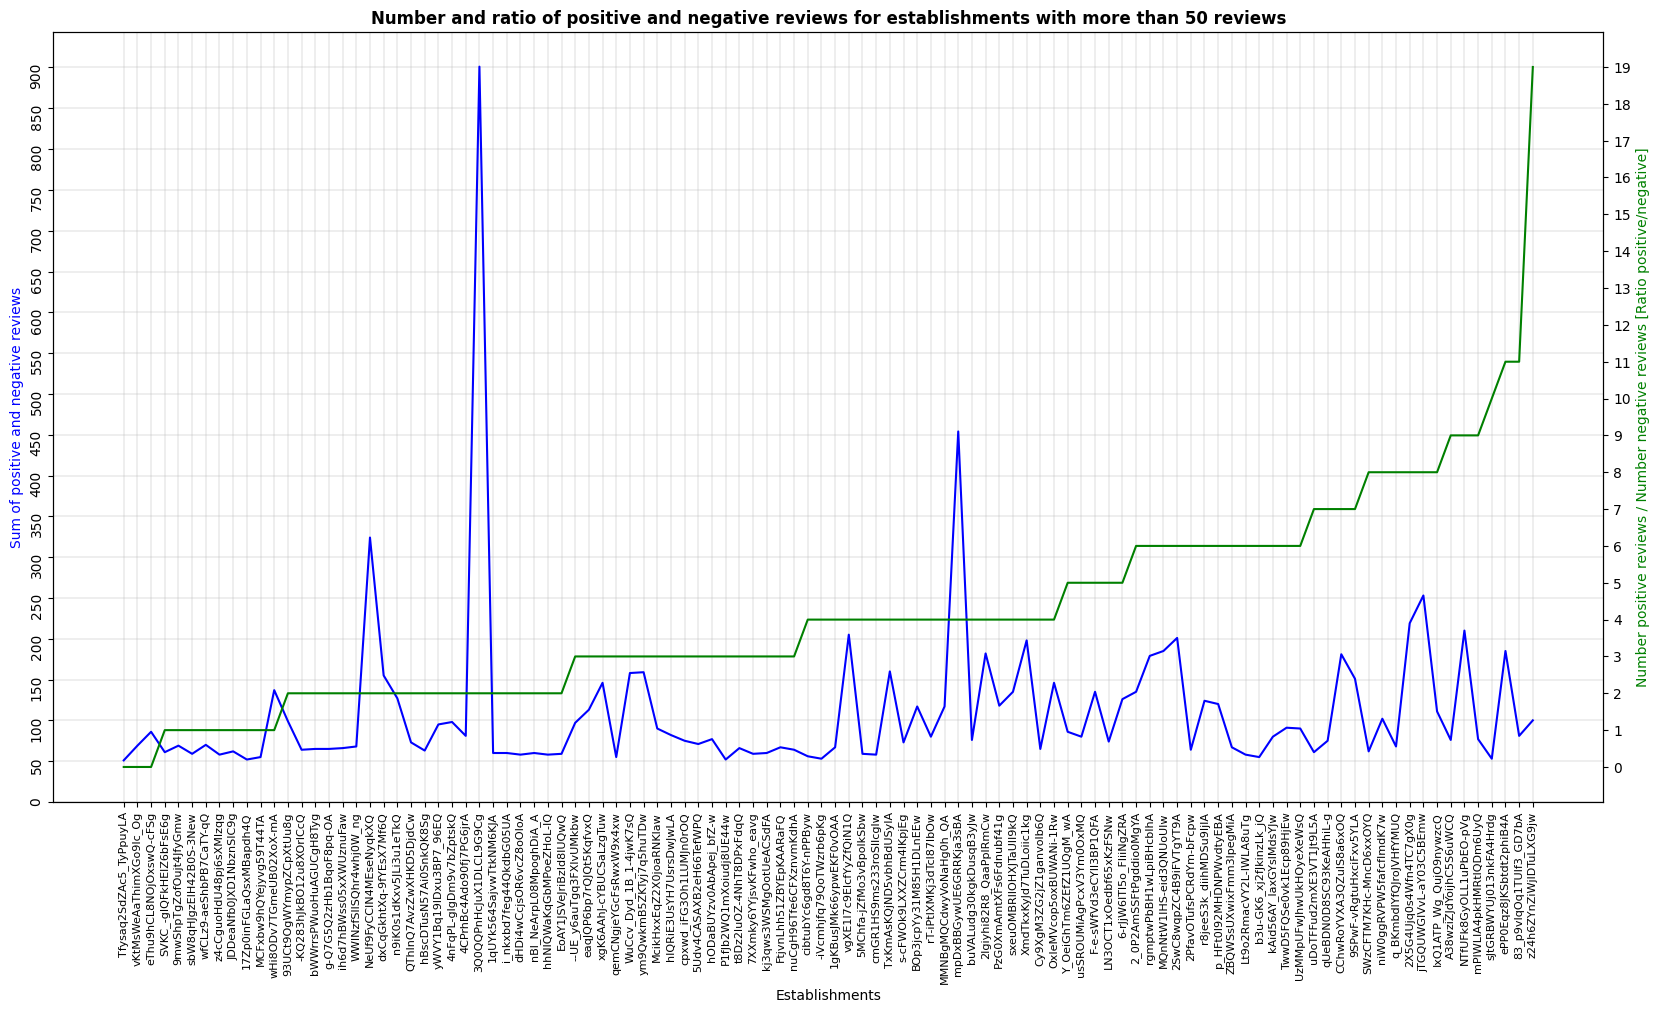

In [20]:
# auxiliar dataframe for twinxs plots
aux = df.copy()
aux[['negative', 'neutral', 'positive']] = tf.one_hot(aux['sentiment_bert_clean_bina'], aux['sentiment_bert_clean_bina'].nunique()) # encoding the sentiment
aux = aux.groupby(['business_id'], as_index=False).aggregate({'negative': 'sum', 'neutral': 'sum', 'positive': 'sum'}) # grouping by business_id
aux['n_posNeg_reviews'] = aux['negative'] + aux['positive'] # sum of negative and positives reviews
aux['posNeg_ratio'] = round((aux['positive'] / (aux['negative']+1))) # ratio between positive and negatives reviews (adding 1 because ZeroDivision)
aux50 = aux.loc[aux['n_posNeg_reviews'] > 50] # establishments with more than 50 positives and negatives reviews

# ploting twinx
title = 'Number and ratio of positive and negative reviews for establishments with more than 50 reviews'
labelYLeft = 'Sum of positive and negative reviews'
labelYRight = 'Number positive reviews / Number negative reviews [Ratio positive/negative]'

# data sorted by number of reviews
aux50 = aux50.sort_values('n_posNeg_reviews')
twice_lineplot(x=aux50['business_id'], yLeft=aux50['n_posNeg_reviews'], yRight=aux50['posNeg_ratio'],
               title=title, labelYLeft=labelYLeft, labelYRight=labelYRight)

# data sorted by the positive/negative ratio
aux50 = aux50.sort_values('posNeg_ratio')
twice_lineplot(x=aux50['business_id'], yLeft=aux50['n_posNeg_reviews'], yRight=aux50['posNeg_ratio'],
               title=title, labelYLeft=labelYLeft, labelYRight=labelYRight)

## how consistent are the stars with the reviews?

### lets see the next review

3 stars (neutral)

0 with bert (negative)

reading the review it is clear that it is negative, there may be a lack of consistency between the text and the stars and bert analysis is able to detect it

In [189]:
df.loc[df['review_id'] == 'RmXtD5UMw8-p21ER6krgUA', ['review_id', 'text', 'clean_text', 'core_text', 'stars', 'category_stars', 'sentiment_blob', 'sentiment_bert_clean_bina', 'sentiment_bert_core_bina']]

,review_id,text,clean_text,core_text,stars,category_stars,sentiment_blob,sentiment_bert_clean_bina,sentiment_bert_core_bina
26386,RmXtD5UMw8-p21ER6krgUA,"Beautiful things in this store.. Too expensive in my opinion but my main problem with this place is that the two experiences I've had with the one owner, he was extremely rude to me. I happened to be in there when the store was closing (I had been in there maybe 5 minutes) and he turns to me and tells me that the 'store is closing and it's time to go home now.' At first I thought he was joking but he was completely serious and quickly walked away from me. Like I've said in my other posts I love supporting small independent businesses but I don't appreciate being treated disrespectfully. A little kindness and friendliness goes a long way, which I disappointingly didn't receive here. Likely will not be shopping here again when there are equally nice and talented florists in the area.. Not to mention cheaper.",beautiful thing store expensive opinion main problem place experience owner extremely rude happen store close maybe minute turn tell store close time home think joke completely quickly walk away like say post love support small independent business appreciate treat disrespectfully little kindness friendliness go long way disappointingly receive likely shop equally nice talented florist area mention cheap,beautiful thing store expensive opinion main problem place experience owner extremely rude happen store close maybe minute turn tell store close time home think joke completely quickly walk away say love support small independent business appreciate treat disrespectfully little kindness friendliness go long way disappointingly receive likely shop equally nice talented florist area mention cheap,3,1,1,0,0


In [74]:
# percentage of consistency between stars and bert
print(f'Percentage of consistency between stars and bert: {round(((df["category_stars"] == df["sentiment_bert_clean_bina"]).sum())/df.shape[0]*100)}%')

Percentage of consistency between stars and bert: 70%


# could the category_stars be a possible target?

In [ ]:
# ploting number of reviews through years
plt.figure(figsize=(20, 10))
ax = sns.countplot(data=df, x='year')
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('Year')
plt.ylabel('Reviews count')
plt.grid(linewidth=0.3)
plt.title('Number of reviews through years', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

# comparison between our dataset reviews and macro analysis
Image('GoogleRevGrow.png')

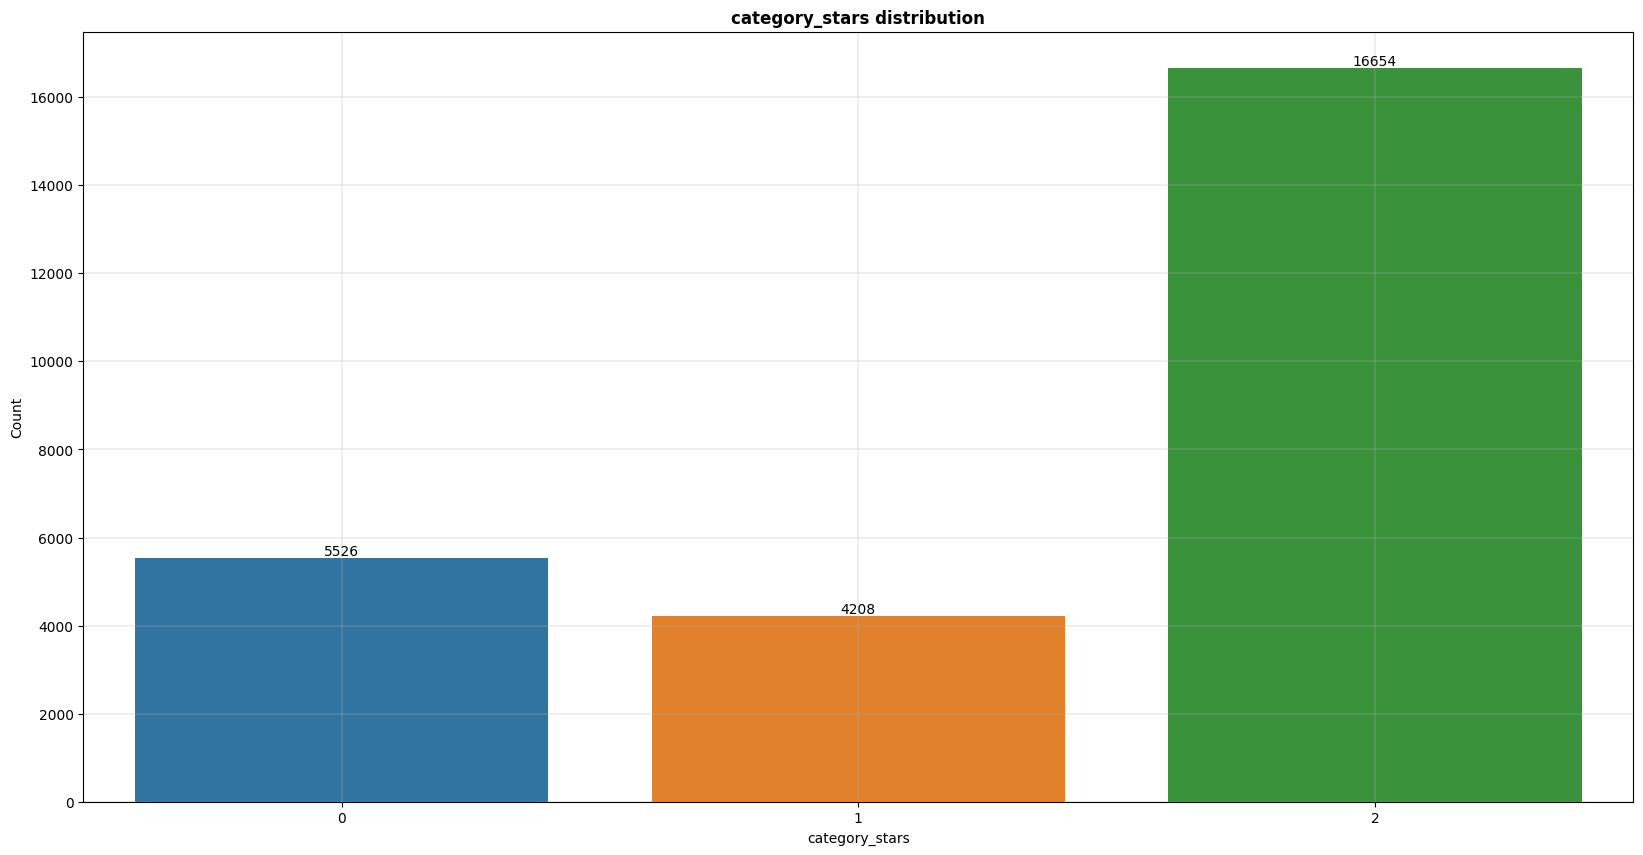

In [205]:
# ploting category_stars distribution
plt.figure(figsize=(20, 10))
ax = sns.countplot(data=df, x='category_stars')
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('category_stars')
plt.ylabel('Count')
plt.grid(linewidth=0.3)
plt.title('category_stars distribution', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

In [102]:
# report function
def report(X, y, model, df_model):
    """
    in: X, y, model, df_model
    out: print a best_params_, train_score, test_score, clasification_report and plot the confusion_matrix
    """

    print(f'best_params_: {model.best_params_}')
    train_score = float(df_model.loc[df_model['rank_test_score'] == 1, 'mean_train_score'])
    print(f'Train_score: {train_score}')
    print(f'Test_score_: {model.best_score_}')

    y_test_hat = model.best_estimator_.predict(X)
    clasification_report = classification_report(y, y_test_hat)
    print(clasification_report)

    confusion = confusion_matrix(y, y_test_hat)
    disp = ConfusionMatrixDisplay(confusion)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

In [103]:
# X and y
X = df['clean_text'].copy()
y = df['category_stars'].copy()
# y = df['sentiment_bert_clean_bina'].copy()

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

# KFolds definition
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## RandomForestClassifier

best_params_: {'rfc__n_estimators': 112, 'rfc__min_samples_split': 60, 'rfc__min_samples_leaf': 1, 'rfc__max_depth': 42, 'rfc__criterion': 'gini'}
Train_score: 0.9229391535184128
Test_score_: 0.7481498263781864
              precision    recall  f1-score   support

           0       0.67      0.73      0.70      1104
           1       0.45      0.28      0.34       841
           2       0.83      0.88      0.85      3327

    accuracy                           0.75      5272
   macro avg       0.65      0.63      0.63      5272
weighted avg       0.73      0.75      0.74      5272



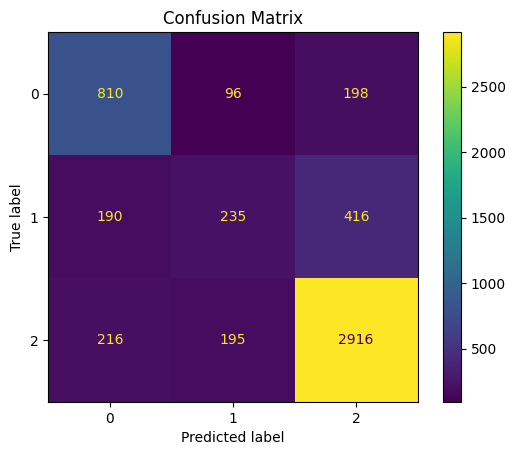

In [197]:
# RandomizedSearchCV RFC with TFIDF and balanced class_weight

pipe_rfc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rfc', RandomForestClassifier(n_jobs=-1, class_weight='balanced',  random_state=42))
])

param_grid = {
            'rfc__n_estimators': [x for x in range(100, 150, 2)],
            'rfc__criterion': ['entropy', 'gini'],
            'rfc__max_depth': [x for x in range(2, 50, 2)],
            'rfc__min_samples_split': [x for x in range(50, 80, 2)],
            'rfc__min_samples_leaf': [x for x in range(1, 10, 1)],
            }

grid_rfc = RandomizedSearchCV(estimator=pipe_rfc,
                                param_distributions=param_grid,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=skf,
                                return_train_score=True,
                                )

grid_rfc.fit(X_train, y_train)

df_rfc = pd.DataFrame(grid_rfc.cv_results_)

# report
report(X_test, y_test, grid_rfc, df_rfc)

best_params_: {'rfc__n_estimators': 134, 'rfc__min_samples_split': 66, 'rfc__min_samples_leaf': 4, 'rfc__max_depth': 46, 'rfc__criterion': 'entropy'}
Train_score: 0.835681062877239
Test_score_: 0.7331621376204295
              precision    recall  f1-score   support

           0       0.65      0.75      0.70      1104
           1       0.41      0.39      0.40       841
           2       0.85      0.82      0.83      3327

    accuracy                           0.74      5272
   macro avg       0.64      0.65      0.64      5272
weighted avg       0.74      0.74      0.74      5272



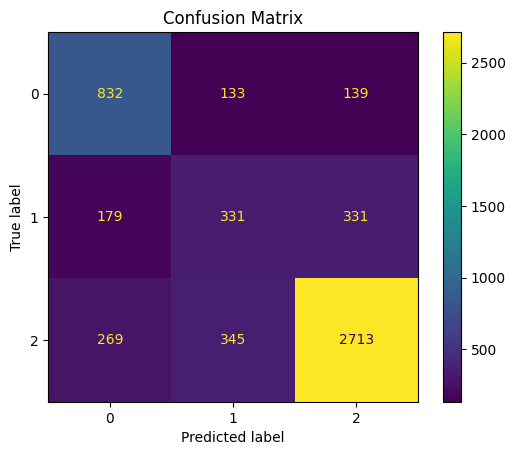

In [200]:
# RandomizedSearchCV RFC with CountVectorizer and balanced class_weight

pipe_rfc = Pipeline([
    ('cvect', CountVectorizer()),
    ('rfc', RandomForestClassifier(n_jobs=-1, class_weight='balanced',  random_state=42))
])

param_grid = {
            'rfc__n_estimators': [x for x in range(100, 150, 2)],
            'rfc__criterion': ['entropy', 'gini'],
            'rfc__max_depth': [x for x in range(2, 50, 2)],
            'rfc__min_samples_split': [x for x in range(50, 80, 2)],
            'rfc__min_samples_leaf': [x for x in range(1, 10, 1)],
            }

grid_rfc = RandomizedSearchCV(estimator=pipe_rfc,
                                param_distributions=param_grid,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=skf,
                                return_train_score=True,
                                )

grid_rfc.fit(X_train, y_train)

df_rfc = pd.DataFrame(grid_rfc.cv_results_)

# report
report(X_test, y_test, grid_rfc, df_rfc)

## MultinomialNB

best_params_: {'tfidf__norm': 'l2', 'mnb__alpha': 0.01}
Train_score: 0.889216951817058
Test_score_: 0.7290836111537334
              precision    recall  f1-score   support

           0       0.79      0.56      0.66      1104
           1       0.34      0.08      0.13       841
           2       0.74      0.96      0.84      3327

    accuracy                           0.74      5272
   macro avg       0.63      0.53      0.54      5272
weighted avg       0.69      0.74      0.69      5272



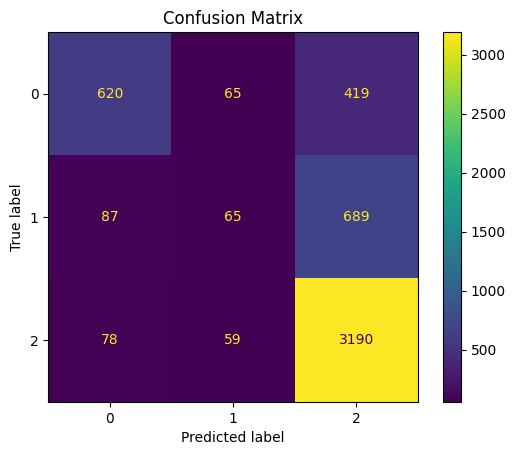

In [201]:
# RandomizedSearchCV MultinomialNB with TFIDF

pipe_mnb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

param_grid = {
            'tfidf__norm': ['l1', 'l2'],
            'mnb__alpha': [1, 0.8, 0.6, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001, 0],
            }

grid_mnb = RandomizedSearchCV(estimator=pipe_mnb,
                                param_distributions=param_grid,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=skf,
                                return_train_score=True,
                                )

grid_mnb.fit(X_train, y_train)

df_mnb = pd.DataFrame(grid_mnb.cv_results_)

# report
report(X_test, y_test, grid_mnb, df_mnb)

best_params_: {'mnb__alpha': 1}
Train_score: 0.8392026698463176
Test_score_: 0.746917003508434
              precision    recall  f1-score   support

           0       0.71      0.68      0.70      1104
           1       0.39      0.25      0.31       841
           2       0.81      0.90      0.85      3327

    accuracy                           0.75      5272
   macro avg       0.64      0.61      0.62      5272
weighted avg       0.72      0.75      0.73      5272



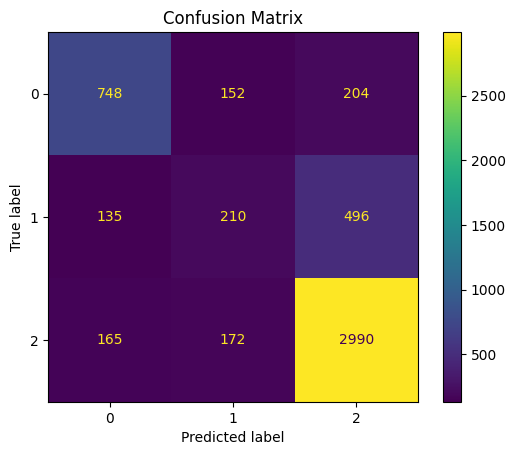

In [202]:
# RandomizedSearchCV MultinomialNB with CountVectorizer

pipe_mnb = Pipeline([
    ('cvect', CountVectorizer()),
    ('mnb', MultinomialNB())
])

param_grid = {
            'mnb__alpha': [1, 0.8, 0.6, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001, 0],
            }

grid_mnb = RandomizedSearchCV(estimator=pipe_mnb,
                                param_distributions=param_grid,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=skf,
                                return_train_score=True,
                                )

grid_mnb.fit(X_train, y_train)

df_mnb = pd.DataFrame(grid_mnb.cv_results_)

# report
report(X_test, y_test, grid_mnb, df_mnb)

## saving the dataframe

In [1]:
# saving the file
df.to_csv('reviews_processed.csv')